# Construction of a prediction model for Covid19
## Part 2 of the notebook (for part one look at the fork of covidclinicaldata

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import eli5

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.dummy import DummyClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from colorama import Fore #To pain the terminal with different colors
import warnings
warnings.filterwarnings('ignore') #To disable warnings
from IPython.display import display #To print a dataframe like the cell does

shap.initjs() #So shap values can be displayed inline

In [2]:
all_data = pd.read_csv("covid_clinical_data.csv", index_col=0)
all_data

,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,autoimmune_dis,...,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
0,Negative,4,True,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
1,Negative,2,False,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
2,Negative,1,NaN,NaN,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Negative,3,True,True,False,False,False,False,False,False,...,True,2.0,False,True,False,False,False,False,False,True
4,Negative,1,False,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93989,Negative,3,False,True,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
93990,Negative,3,False,True,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,True,False,True
93991,Negative,3,False,False,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
93993,Negative,3,False,False,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False


In [3]:
X = all_data.iloc[:, 1:]
y = all_data["covid19_test_results"]

In [4]:
def create_different_datasets(data_x):
    e_factors = data_x.iloc[:,:3]
    comorbidities_data = data_x.iloc[:, 3:10] #The columns that contain the comorbidities
    vitals_data = data_x.iloc[:, 10:16] #The columns that contain the vitals
    assesed_symptoms_data = data_x.iloc[:, 16:21] #The columns that contain the assesed symptoms
    reported_symptoms_data = data_x.iloc[:,21:] #The columns that have the patient reported symptoms
    
    return e_factors, comorbidities_data, vitals_data, assesed_symptoms_data, reported_symptoms_data

In [5]:
e_factors, comorb, vitals, a_symptoms, r_symptoms = create_different_datasets(X)

<u>high_risk_exposure_occupation:</u> The most obvious thing to do is to just fill the 169 missing values with the most frequent value. However, it occurred to me that since we ultimately are willing to have (maybe even encourage) false positives, it might be better to just put the ones that tested positive as True and the rest as False. This would require that I split the dataset into training, validation and testing set before I do any imputation to avoid any target leakage (the effect when knowing the result before hand affects how are we imputing the variables). The step to be taken (if I were to follow that route) would be then to impute the training data that tested positive as True, the rest as False, and any incoming unknown data (validation and test data) as True if we dont know the value of the feature. I might need to run an experiment when I do both.

<u>high_risk_interaction:</u> This is easier than the previous one. We will just assign True to anything that has a 'high_risk_expossure_occupation' as True. The reasoning behind is is that if we don't know if the patient has had a high risk interaction, makes sense to say they did if their occupation is of high risk exposure.

In [6]:
def high_risk_exposure_imputation(data_x, data_y, target_imputation=False):    
    if target_imputation:
        mode = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]
    else:
        mode = True
    data_x.loc[data_x["high_risk_exposure_occupation"].isna(), "high_risk_exposure_occupation"] = mode
    
    data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]

def vitals_imputation_generic(data_x):
    data = data_x.copy()
    data.loc[data["temperature"].isna(),"temperature"] = data["temperature"].mean()
    data.loc[data["pulse"].isna(),"pulse"] = data["pulse"].median()
    data.loc[data["rr"].isna(),"rr"] = data["rr"].median()
    data.loc[data["sats"].isna(),"sats"] = data["sats"].median()
    data.loc[data_x["pam"].isna(), "pam"] = data_x["pam"].mean()
    
    return data


In [7]:
def reduce_training_set(data_x, data_y):
    selected_negatives = data_x[data_y[data_x.index] == "Negative"].sample((data_y[data_x.index] == "Positive").sum())
    all_positives = data_x[data_y == "Positive"]
    #reduced_train_comorb = pd.merge(all_positives, selected_negatives) #Doesn't work well for reasons...
    reduced_data = pd.concat([all_positives, selected_negatives])

    return reduced_data

def specificity_score(*values):    
    cm = confusion_matrix(*values)    
    return cm[0][0] / (cm[0][0] + cm[0][1]) 


def get_metrics(*values):
    accuracy = accuracy_score(*values)
    recall = recall_score(*values, pos_label="Positive")
    precision = precision_score(*values, pos_label="Positive")
    f1 = f1_score(*values, pos_label="Positive")
    specificity = specificity_score(*values)
    return accuracy, recall, precision, specificity, f1 


In [8]:
class Imputer():
    
    def __init__(self):
        self.column_values = {}
        
    def fit_transform(self, data_x, data_y):
        self.fit(data_x, data_y)
        self.transform(data_x, training=True)
        
    def fit(self, data_x, data_y):
        self.get_high_risk_exposure_value(data_x, data_y)
        self.get_vitals_values(data_x)
        self.get_a_symptoms_values(data_x)
        self.get_r_symptoms_values(data_x)
        
    def transform(self, data_x, training=False):
        for feature in data_x.columns:           
            
            if feature in self.column_values:
                new_value = self.column_values[feature]
                
                if feature == "high_risk_exposure_occupation" and not training:
                    new_value=True
                    
                data_x.loc[data_x[feature].isna(), feature] = new_value
                
        if "high_risk_interactions" in data_x.columns: #Because this depends on 'high_risk_exposure_occupation being imputed first'
            data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]
        
        
        
    def get_high_risk_exposure_value(self, data_x, data_y):
        if "high_risk_exposure_occupation" in data_x.columns:
            self.column_values["high_risk_exposure_occupation"] = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]

        
    def get_vitals_values(self, data_x):
        if "temperature" in data_x.columns:
            self.column_values["temperature"] =  data_x["temperature"].mean()
        if "pulse" in data_x.columns:
            self.column_values["pulse"] = data_x["pulse"].median()
        if "rr" in data_x.columns:
            self.column_values["rr"] = data_x["rr"].median()
        if "sats" in data_x.columns:
            self.column_values["sats"] = data_x["sats"].median()
        if "pam" in data_x.columns:
            self.column_values["pam"] =  data_x["pam"].mean()
            
    def get_a_symptoms_values(self, data_x):
        
        if "ctab" in data_x.columns:
            self.column_values["ctab"] = data_x["ctab"].mode()[0]
            
        if "labored_respiration" in data_x.columns:
            self.column_values["labored_respiration"] = data_x["labored_respiration"].mode()[0]
            
        if "rhonchi" in data_x.columns:
            self.column_values["rhonchi"] = data_x["rhonchi"].mode()[0]
            
        if "wheezes" in data_x.columns:
            self.column_values["wheezes"] = data_x["wheezes"].mode()[0]
            
        if "days_since_symptom_onset" in data_x.columns:
            self.column_values["days_since_symptom_onset"] = data_x["days_since_symptom_onset"].median()
            
    def get_r_symptoms_values(self, data_x):
        if "cough" in data_x.columns:
            self.column_values["cough"] = data_x["cough"].mode()[0]
            
        if "cough_severity" in data_x.columns:
            self.column_values["cough_severity"] = data_x["cough_severity"].mode()[0]
            
        if "fever" in data_x.columns:
            self.column_values["fever"] = data_x["fever"].mode()[0]
            
        if "sob" in data_x.columns:
            self.column_values["sob"] = data_x["sob"].mode()[0]
            
        if "sob_severity" in data_x.columns:
            self.column_values["sob_severity"] = data_x["sob_severity"].mode()[0]
        
        if "diarrhea" in data_x.columns:
            self.column_values["diarrhea"] = data_x["diarrhea"].mode()[0]
            
        if "fatigue" in data_x.columns:
            self.column_values["fatigue"] = data_x["fatigue"].mode()[0]
            
        if "headache" in data_x.columns:
            self.column_values["headache"] = data_x["headache"].mode()[0]
            
        if "loss_of_smell" in data_x.columns:
            self.column_values["loss_of_smell"] = data_x["loss_of_smell"].mode()[0]
            
        if "loss_of_taste" in data_x.columns:
            self.column_values["loss_of_taste"] = data_x["loss_of_taste"].mode()[0]
    
        if "runny_nose" in data_x.columns:
            self.column_values["runny_nose"] = data_x["runny_nose"].mode()[0]
            
        if "muscle_sore" in data_x.columns:
            self.column_values["muscle_sore"] = data_x["muscle_sore"].mode()[0]
            
        if "sore_throat" in data_x.columns:
            self.column_values["sore_throat"] = data_x["sore_throat"].mode()[0]

In [9]:
class XGBAdapter:
    
    def __init__(self, **params):
        self.model = XGBClassifier(**params, verbosity=0)
        
    def fit(self, data_x, data_y, sample_weight=None):
        self.model.fit(self.xgb_adapter(data_x), data_y, sample_weight=sample_weight)
        
    def predict(self, data_x):
        return self.model.predict(self.xgb_adapter(data_x))
    
    def predict_proba(self, data_x):
        return self.model.predict_proba(self.xgb_adapter(data_x))
    
    #This function is because xgb complains about 'object' type columns so I convert them all to boolean
    def xgb_adapter(self, data_x):
        result = data_x.copy()
        for column in result:
            if data_x[column].dtype == "object":
                result.loc[:,column] = result[column].astype("bool")
        return result

In [10]:
def calculate_shap_values(model, data_x):
    explainer = shap.KernelExplainer(model.predict_proba, np.zeros((1, data_x.shape[1])))
    sample = data_x.sample(1)
    display(shap.force_plot(explainer.expected_value[1], explainer.shap_values(sample)[1], sample))
    
def permutation_importance(model, X, Y, num_shuffles=50):
    feature_score_difference = np.full((len(X.columns), num_shuffles), 0, dtype=float)
    og_predictions = model.predict(X)
    og_error = accuracy_score(Y, og_predictions)
    for i in range(len(X.columns)): # Para cada feature
        feature = X.columns[i]
        shuffled_values = pd.DataFrame(X, copy = True) # Para que no afecte el dataset original solo copiamos los valores
        for j in range(num_shuffles):
            np.random.shuffle(shuffled_values[feature].values)
            col_preds = model.predict(shuffled_values)
            col_error = accuracy_score(Y, col_preds)
            feature_score_difference[i][j] = col_error - og_error # og tiene que ser mas pequeño
    result_table = np.array([feature_score_difference.mean(axis=1), feature_score_difference.std(axis=1)])
    
    df = pd.DataFrame(np.transpose(result_table), columns=["Importancia", "Desviacion estándar"], index=X.columns)
    return df.sort_values(by="Importancia", ascending = False)

In [11]:
def cross_validation_normal(data_x, data_y, model, folds, sample_weights=None):
    results = np.zeros((folds,2,5)) #Shape of folds, training and validation, and number of metrics
    if sample_weights is None:
        sample_weights = np.ones(data_y.shape)
       
    fold_size = data_x.shape[0] // folds
    reminder = data_x.shape[0] % folds    
    start = 0    
    imputer = Imputer()
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1
        train_x = pd.concat([data_x.iloc[:start], data_x.iloc[end:]], axis=0)
        train_y = data_y.iloc[:start].append(data_y.iloc[end:])
        valid_x = data_x.iloc[start:end]
        valid_y = data_y.iloc[start:end]
                    
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
            
        model.fit(train_x, train_y, sample_weight=np.append(sample_weights[:start], sample_weights[end:]))
        train_v = (train_y, model.predict(train_x))
        valid_v = (valid_y, model.predict(valid_x))
        results[i,0] += get_metrics(*train_v)
        results[i,1] += get_metrics(*valid_v)
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
    print("")    
       
    
    return results.mean(axis=0)



def cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=1, class_threshold=.5):
    
    positive_index = data_y[data_y == "Positive"].index
    size_of_negatives = positive_index.shape[0] * ratio_negatives_to_positives
    
    fold_size = positive_index.shape[0] // folds
    results = np.zeros((folds,2,6)) #Shape of folds, training and validation, and number of metrics   
        
    reminder = positive_index.shape[0] % folds
    
    imputer = Imputer()
    start = 0    
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1        
        training_positives = np.setdiff1d(positive_index, positive_index[start:end]) #The index of positives to be used as training set
                
        # Sample the size of negatives- the size of the fold negatives for training and concatenate with the corresponding indexes for the fold
        train_x = pd.concat([data_x[data_y == "Negative"].sample(size_of_negatives - fold_size), data_x.loc[training_positives]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        train_y = data_y[train_x.index]
        valid_x = pd.concat([data_x[data_y == "Negative"].sample(fold_size * ratio_negatives_to_positives), data_x.loc[positive_index[start:end]]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        valid_y = data_y[valid_x.index]
        
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
                    
        model.fit(train_x, train_y)
        
        ##The following lines are for predicting via probability
        t_pred_prob = model.predict_proba(train_x)[:,1] ## We choose '1' in predict_proba since that is the positive class
        v_pred_prob = model.predict_proba(valid_x)[:,1]  ## We choose '1' in predict_proba since that is the positive class      
               
        t_preds = np.zeros(train_x.shape[0], dtype = np.object)
        t_preds[t_pred_prob > class_threshold] = "Positive"
        t_preds[t_pred_prob <= class_threshold] = "Negative"
        
        v_preds = np.zeros(valid_x.shape[0], dtype = np.object)
        v_preds[v_pred_prob > class_threshold] = "Positive"
        v_preds[v_pred_prob <= class_threshold] = "Negative"
        
        ##End of probability calculations
        
        train_v = (train_y, t_preds) #original: insted of t_preds is model.predict
        valid_v = (valid_y, v_preds)  #original: insted of v_preds is model.predict
        results[i,0] += get_metrics(*train_v) + (roc_auc_score(train_y, t_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        results[i,1] += get_metrics(*valid_v) + (roc_auc_score(valid_y, v_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
                    
    print("")
    
    try:

        train_shap_x = pd.concat([data_x[data_y == "Negative"].sample((size_of_negatives - fold_size) // 2), data_x.loc[positive_index].sample((size_of_negatives - fold_size) // 2)], axis=0)
        
        test_shap_x = data_x.loc[np.setdiff1d(data_x.index.values, train_shap_x.index.values)].sample(fold_size)

        imputer.fit_transform(train_shap_x, data_y[train_shap_x.index])
        imputer.transform(test_shap_x)
        model.fit(train_shap_x, data_y[train_shap_x.index])
        #explainer = shap.KernelExplainer(model.predict_proba, np.zeros((1, data_x.shape[1])))
        #sample = data_x.sample(fold_size)
        #display(shap.force_plot(explainer.expected_value[1], explainer.shap_values(sample)[1], sample))
        #display(permutation_importance(model, test_shap_x, y[test_shap_x.index], 5)) ## Doesn't seem to be working very well
        display(eli5.show_weights(model, feature_names=list(data_x.columns)))
        
        roc_values = roc_curve(data_y[test_shap_x.index], model.predict_proba(test_shap_x)[:,1], pos_label="Positive", drop_intermediate=False)
        plt.plot(roc_values[0], roc_values[1], 'b-')
        plt.xlabel("FPR (1-specificity)")
        plt.ylabel("TPR (recall)")
        plt.show()
        
        
    except Exception as e:
        print(e)
    
    
    return results.mean(axis=0)

   
        
def run_models(data_x, data_y, models, folds=10, ratio_negatives_to_positives=-1, sample_weights=None):
    for model in models:
        print(Fore.RED, model, Fore.BLACK, sep="")
        try:
            if(ratio_negatives_to_positives >= 1):            
                results = cross_validation_class_ratios(data_x, data_y, models[model], folds, ratio_negatives_to_positives)
            else:
                results = cross_validation_normal(data_x, data_y, models[model], folds, sample_weights)    

            display(pd.DataFrame(results, index=["Training", "Validation"], columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"]))
            print("")
        except Exception as e:
            print(e)

In [12]:
models ={
    "Dummy Random" : DummyClassifier(strategy="uniform"),
    "MultinomialNB" : MultinomialNB(alpha=0, class_prior=(.5, .5)),
    "Random Forest (100 estimators)" : RandomForestClassifier(min_samples_leaf=100),
    "XGBoost Classifier" : XGBAdapter(n_estimators=500),
    "SVM" : SVC(kernel='linear', probability=True), 
    "KNN" : KNeighborsClassifier(n_neighbors=100, weights="distance"), 
    "Logistic Regression" : LogisticRegression()
}

<i>Note: I tried to calculate data with the imbalanced datasets (cross validation with all positive and negative examples) and discovered that it didn't work so I deleted those experiments so the notebook looks cleaner with the ones that count</i>


Next step to either add more features or... implement a cross validation method that makes up for the difference between positives and negatives

In [13]:
comorb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51695 entries, 0 to 93994
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   diabetes        51695 non-null  bool 
 1   chd             51695 non-null  bool 
 2   htn             51695 non-null  bool 
 3   cancer          51695 non-null  bool 
 4   asthma          51695 non-null  bool 
 5   autoimmune_dis  51695 non-null  bool 
 6   smoker          51695 non-null  bool 
dtypes: bool(7)
memory usage: 757.3 KB


Dummy Random
╠■■■■■■■■■╣


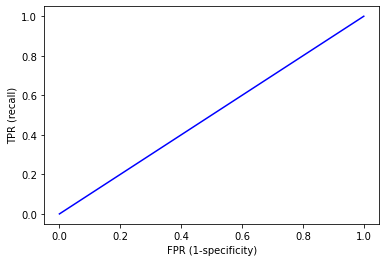

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500045,0.0,0.0,1.0,0.0,0.5
Validation,0.499592,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


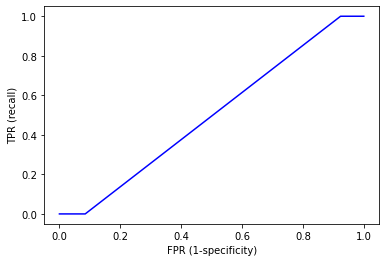

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.506228,0.072651,0.559854,0.939727,0.126997,0.519709
Validation,0.505728,0.071991,0.523072,0.940164,0.125492,0.524070



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0 ± 0.0000,smoker
0 ± 0.0000,autoimmune_dis
0 ± 0.0000,asthma
0 ± 0.0000,cancer
0 ± 0.0000,htn
0 ± 0.0000,chd
0 ± 0.0000,diabetes


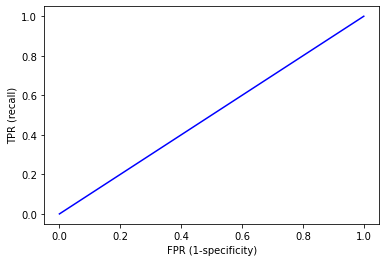

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500818,0.866624,0.450416,0.135091,0.592590,0.50113
Validation,0.493862,0.856691,0.446933,0.130328,0.587204,0.49187



XGBoost Classifier
╠■■■■■■■■■╣


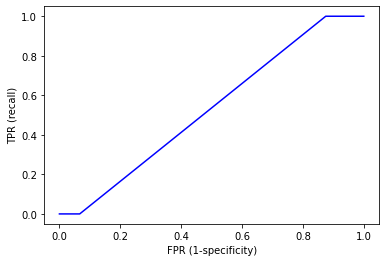

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.519183,0.884435,0.511129,0.154000,0.647736,0.528117
Validation,0.504503,0.875583,0.502558,0.132787,0.638209,0.504975



SVM
╠■■■■■■■■■╣


Weight?,Feature
+1.000,<BIAS>
+0.000,diabetes
-0.000,htn
-1.000,cancer
-2.000,asthma
-2.000,smoker


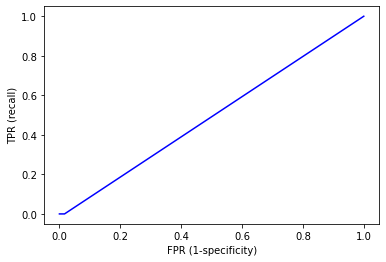

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.499135,0.403928,0.422829,0.594273,0.328563,0.498758
Validation,0.497133,0.401466,0.441964,0.593443,0.331793,0.498310



KNN
╠■■■■■■■■■╣


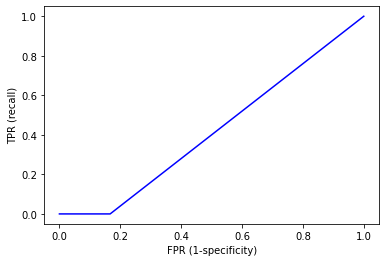

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.510365,0.042732,0.715953,0.977909,0.077115,0.500995
Validation,0.496306,0.033533,0.500411,0.959836,0.060867,0.494239



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+1.209,diabetes
+0.444,cancer
+0.101,htn
-0.004,<BIAS>
-0.129,asthma
-0.198,smoker
-0.454,autoimmune_dis
-0.458,chd


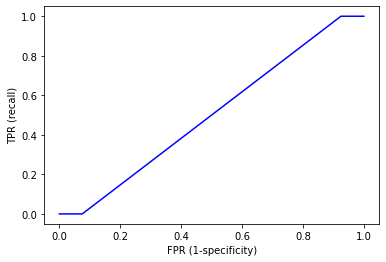

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.512955,0.825253,0.511418,0.200727,0.600726,0.519449
Validation,0.502451,0.809203,0.492376,0.195082,0.587672,0.508086


In [14]:
run_models(comorb, y[comorb.index], models, ratio_negatives_to_positives = 1)

Dummy Random
╠■■■■■■■■■╣


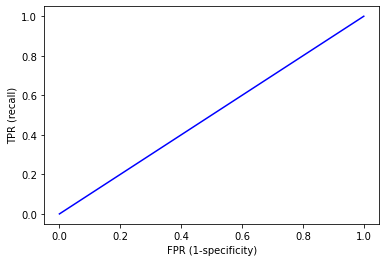

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500045,0.0,0.0,1.0,0.0,0.5
Validation,0.499592,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


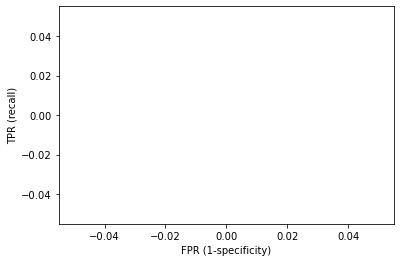

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.529957,0.194394,0.591802,0.865455,0.291695,0.562912
Validation,0.515552,0.175870,0.545388,0.855738,0.264961,0.534710



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.6076 ± 0.8771,high_risk_interactions
0.3924 ± 0.7450,high_risk_exposure_occupation
0 ± 0.0000,autoimmune_dis
0 ± 0.0000,asthma
0 ± 0.0000,cancer
0 ± 0.0000,htn
0 ± 0.0000,chd
0 ± 0.0000,diabetes


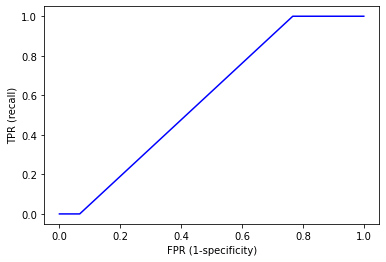

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.534595,0.597064,0.551767,0.472182,0.506815,0.553646
Validation,0.507362,0.569079,0.499408,0.445082,0.464880,0.531136



XGBoost Classifier
╠■■■■■■■■■╣


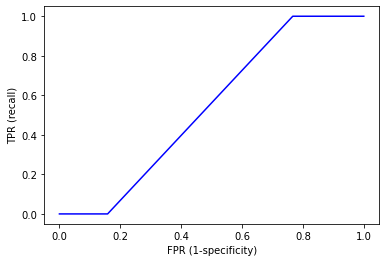

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.547595,0.852701,0.529562,0.242545,0.653290,0.573667
Validation,0.527439,0.838751,0.516877,0.215574,0.639218,0.549052



SVM
╠■■■■■■■■■╣


Weight?,Feature
+1.750,high_risk_exposure_occupation
+1.000,diabetes
+0.250,cancer
-0.250,htn
-0.250,high_risk_interactions
-0.750,<BIAS>


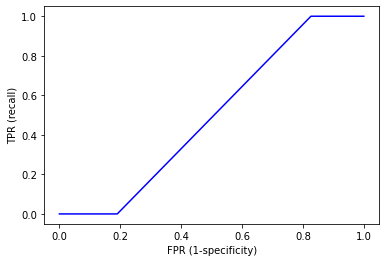

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.528548,0.355968,0.583479,0.701182,0.363309,0.551729
Validation,0.518439,0.328275,0.573474,0.708197,0.334461,0.547729



KNN
╠■■■■■■■■■╣


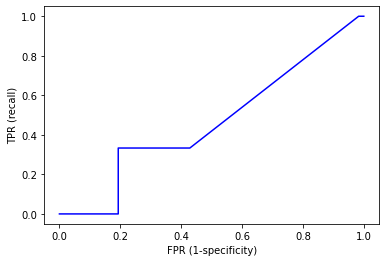

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.517319,0.066280,0.706835,0.968273,0.117524,0.546776
Validation,0.503673,0.047448,0.587515,0.960656,0.083853,0.543172



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+0.729,diabetes
+0.648,high_risk_exposure_occupation
+0.127,htn
+0.018,<BIAS>
-0.051,chd
-0.147,cancer
-0.337,autoimmune_dis
-0.401,asthma
-0.541,high_risk_interactions


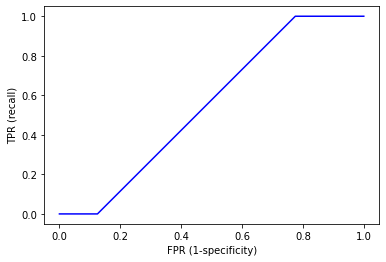

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.536822,0.583602,0.551411,0.490091,0.513390,0.558727
Validation,0.509421,0.547934,0.496296,0.470492,0.473302,0.529808


In [15]:
comorb_ef = pd.concat([comorb.drop(columns="smoker"), e_factors.drop(columns="age")], axis=1)
run_models(comorb_ef, y[comorb_ef.index], models, ratio_negatives_to_positives = 1)

We definetley need another set, even though using the cross validation for data imbalancing helped a lot

### Vitals

$ PAM = DIA + \frac{SIS-DIA}{3}$<br>
where PAM = Presión arterial media
SIS = Sístole
DIA = Diástole

In [16]:
def calculate_pam(data_x):
    return vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)

In [17]:
pam = vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)
vitals = pd.concat([vitals, pam], axis=1)
vitals.rename({ 0 : "pam"}, axis=1,inplace =True) #To rename the column that was appended (which has a value of 0 that is not a string)
i = vitals[vitals.iloc[:,-1] >145].iloc[:,-1].index
pd.concat([vitals.loc[i, ["sys", "dia"]], e_factors.loc[i,"age"]], axis=1)

,sys,dia,age
5135,195.0,135.0,4
6106,215.0,115.0,4
9058,200.0,120.0,3
11792,190.0,130.0,3
14314,205.0,125.0,4
19137,215.0,117.0,4
20168,190.0,130.0,4
20379,220.0,140.0,4
20582,200.0,118.0,4
28579,180.0,130.0,3


As expected, all pressure variables (including pam) are correlated between each other

In [18]:
#Drop all values that are Nan
vitals.dropna(how="all",inplace=True)
vitals.drop(columns=["sys", "dia"], inplace=True) #Because we have 'pam' we don't need it anymore (I ran some experiments and it is sligthly better with 'pam')
vitals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48705 entries, 0 to 93994
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  46961 non-null  float64
 1   pulse        47666 non-null  float64
 2   rr           40972 non-null  float64
 3   sats         46959 non-null  float64
 4   pam          45990 non-null  float64
dtypes: float64(5)
memory usage: 2.2 MB


<AxesSubplot:>

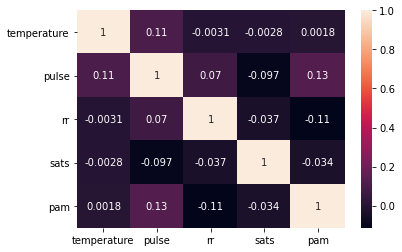

In [19]:
sns.heatmap(vitals.corr(), annot=True)

In [20]:
s_vitals = vitals.copy()
s_vitals = s_vitals.apply(lambda x: (x - x.mean()) / x.std())
n_vitals = vitals.copy()
n_vitals = s_vitals.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

Dummy Random
╠■■■■■■■■■╣


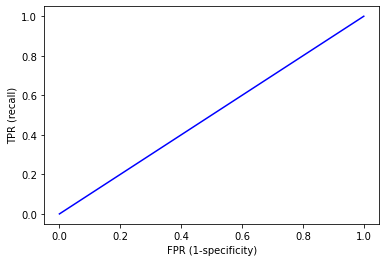

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500227,0.0,0.0,1.0,0.0,0.5
Validation,0.497945,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


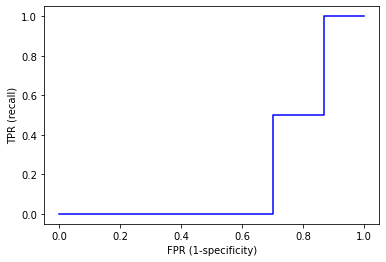

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.564044,0.533718,0.567998,0.594343,0.550271,0.595223
Validation,0.568763,0.535947,0.575279,0.601835,0.552984,0.601311



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.4700 ± 0.6436,temperature
0.3068 ± 0.5769,pulse
0.1729 ± 0.4563,pam
0.0314 ± 0.1347,sats
0.0189 ± 0.1054,rr


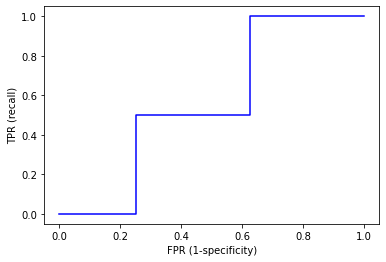

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.613865,0.581538,0.621985,0.646162,0.600669,0.664818
Validation,0.576987,0.552385,0.579836,0.601835,0.563013,0.618901



XGBoost Classifier
╠■■■■■■■■■╣


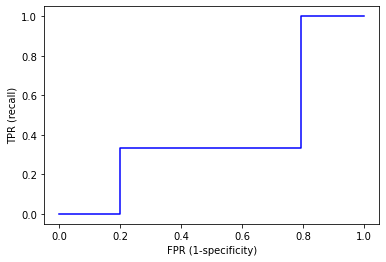

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.997726,0.997574,0.997877,0.997879,0.997725,0.999974
Validation,0.570148,0.558732,0.574145,0.581651,0.565648,0.594256



SVM
╠■■■■■■■■■╣


Weight?,Feature
+1.354,temperature
+0.057,rr
+0.034,pulse
+0.006,pam
-0.025,sats
-51.678,<BIAS>


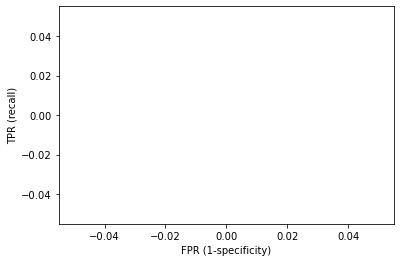

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.588652,0.537056,0.598526,0.640202,0.566108,0.635472
Validation,0.582942,0.535988,0.591482,0.630275,0.559390,0.623185



KNN
╠■■■■■■■■■╣


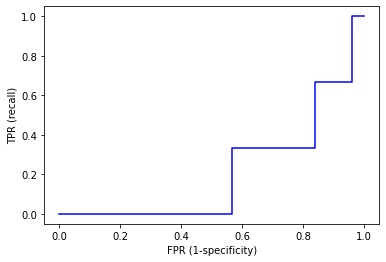

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.998333,0.996866,0.999797,0.999798,0.998328,0.999993
Validation,0.560523,0.570592,0.561313,0.550459,0.564616,0.593289



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+0.293,temperature
+0.035,rr
+0.020,pulse
+0.009,pam
-0.006,<BIAS>
-0.140,sats


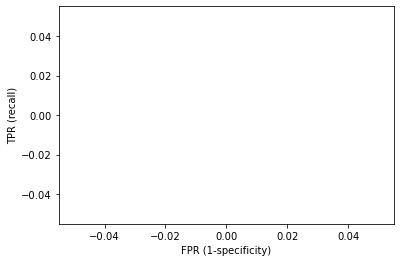

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.592390,0.559295,0.598747,0.625455,0.578324,0.633481
Validation,0.587049,0.554212,0.590979,0.620183,0.569648,0.634050


In [21]:
run_models(vitals, y[vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


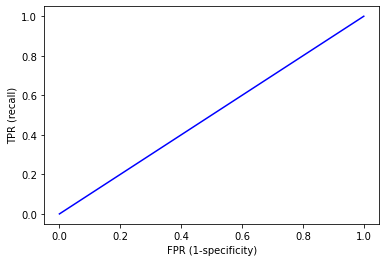

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500227,0.0,0.0,1.0,0.0,0.5
Validation,0.497945,0.0,0.0,1.0,0.0,0.5



MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.4738 ± 0.5920,pulse
0.3753 ± 0.5532,temperature
0.0551 ± 0.1974,rr
0.0533 ± 0.1523,pam
0.0426 ± 0.2378,sats


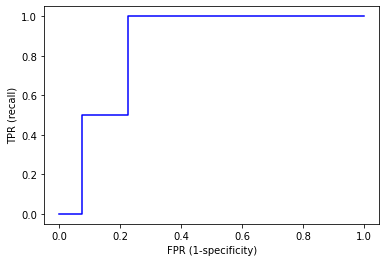

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.614067,0.588719,0.62009,0.639394,0.603737,0.663262
Validation,0.583377,0.555121,0.58877,0.611927,0.568630,0.631031



XGBoost Classifier
╠■■■■■■■■■╣


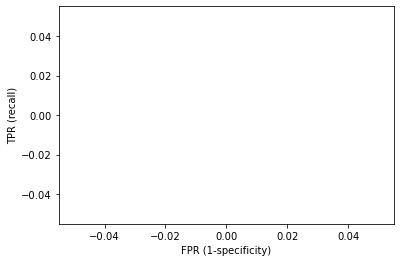

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.997423,0.996866,0.997978,0.997980,0.997420,0.999977
Validation,0.546372,0.531376,0.549756,0.561468,0.539979,0.571713



SVM
╠■■■■■■■■■╣


Weight?,Feature
+0.477,temperature
+0.403,pulse
+0.235,pam
+0.184,rr
-0.031,sats
-0.332,<BIAS>


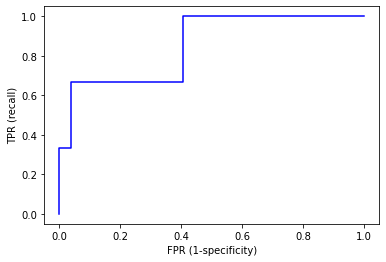

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.596635,0.542009,0.608255,0.651212,0.573201,0.638422
Validation,0.587508,0.530567,0.595765,0.644954,0.558453,0.641339



KNN
╠■■■■■■■■■╣


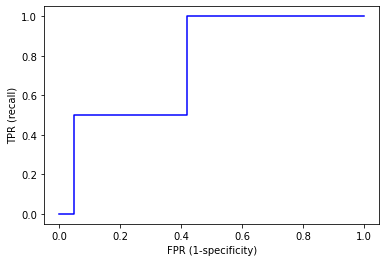

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.998484,0.997068,0.999899,0.999899,0.998481,0.999994
Validation,0.581098,0.514195,0.590957,0.648624,0.546640,0.624055



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+0.283,rr
+0.273,temperature
+0.267,pulse
+0.099,pam
+0.048,sats
-0.117,<BIAS>


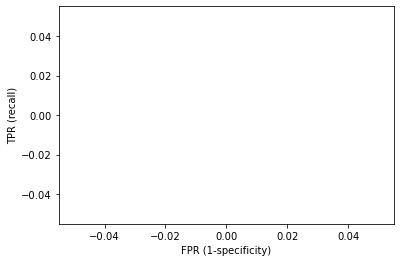

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.593654,0.560106,0.600152,0.627172,0.579431,0.639469
Validation,0.587964,0.558782,0.590032,0.617431,0.572335,0.624675


In [22]:
run_models(s_vitals, y[s_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


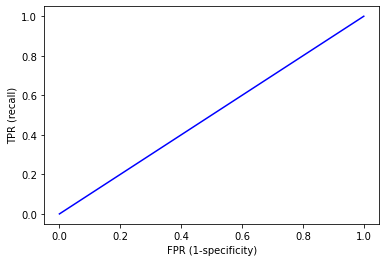

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500227,0.0,0.0,1.0,0.0,0.5
Validation,0.497945,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


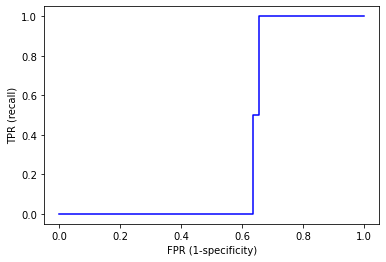

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.575261,0.540795,0.580633,0.609697,0.559975,0.606085
Validation,0.561032,0.530559,0.565097,0.591743,0.545786,0.586439



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.4804 ± 0.6118,temperature
0.3564 ± 0.5518,pulse
0.1085 ± 0.3081,pam
0.0344 ± 0.1537,rr
0.0204 ± 0.1088,sats


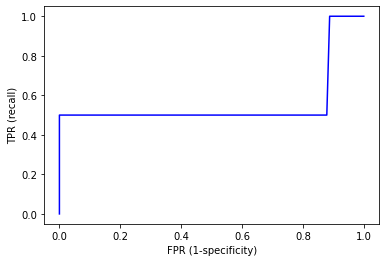

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.612602,0.557273,0.627187,0.667879,0.589486,0.665909
Validation,0.589785,0.535129,0.598612,0.644954,0.562344,0.631656



XGBoost Classifier
╠■■■■■■■■■╣


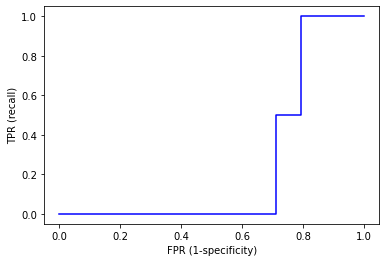

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.998333,0.998382,0.998283,0.998283,0.998332,0.999991
Validation,0.540878,0.544137,0.541958,0.537615,0.542216,0.569440



SVM
╠■■■■■■■■■╣


Weight?,Feature
+4.733,temperature
+3.598,pulse
+1.375,rr
+1.234,pam
-1.134,sats
-3.424,<BIAS>


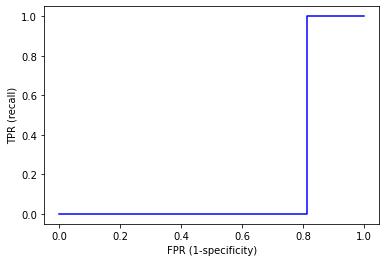

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.589359,0.536347,0.599653,0.642323,0.566230,0.636133
Validation,0.582940,0.534178,0.591927,0.632110,0.559683,0.628040



KNN
╠■■■■■■■■■╣


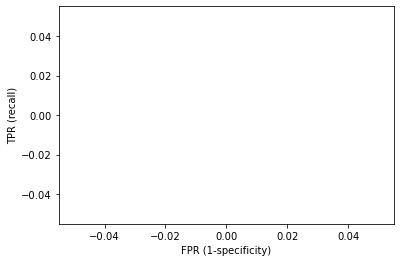

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.998686,0.997574,0.999798,0.999798,0.998683,0.999995
Validation,0.586109,0.523228,0.598412,0.649541,0.555683,0.622029



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+2.814,temperature
+1.823,pulse
+0.524,rr
+0.423,pam
-0.142,sats
-2.154,<BIAS>


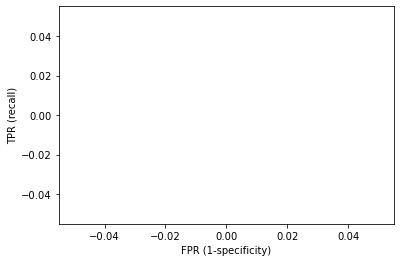

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.593906,0.554645,0.601705,0.633131,0.577199,0.639389
Validation,0.592531,0.556038,0.597599,0.629358,0.574016,0.624418


In [23]:
run_models(n_vitals, y[n_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


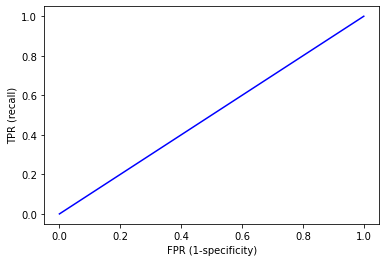

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500227,0.0,0.0,1.0,0.0,0.5
Validation,0.497945,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


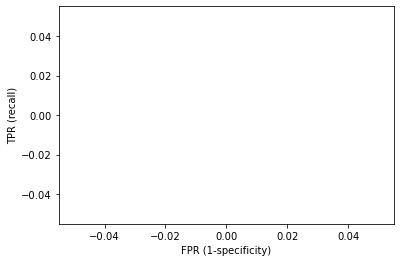

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.558638,0.510778,0.566208,0.606465,0.534313,0.588042
Validation,0.537217,0.488482,0.543310,0.586239,0.511401,0.563158



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.3455 ± 0.6223,temperature
0.2385 ± 0.6149,pulse
0.1798 ± 0.4429,pam
0.1037 ± 0.4099,age
0.0570 ± 0.2850,sats
0.0372 ± 0.1950,rr
0.0335 ± 0.2199,high_risk_exposure_occupation
0.0048 ± 0.0900,high_risk_interactions


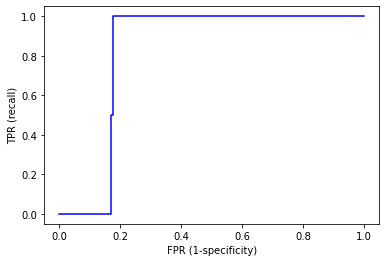

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.619069,0.60550,0.622422,0.632626,0.613688,0.672964
Validation,0.591615,0.57603,0.592866,0.607339,0.582730,0.631106



XGBoost Classifier
╠■■■■■■■■■╣


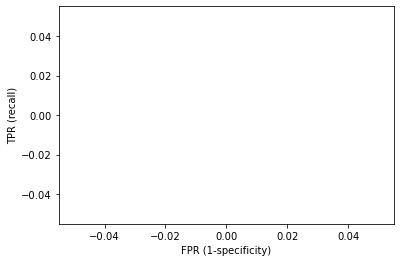

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.999596,0.999697,0.999495,0.999495,0.999596,0.999999
Validation,0.546820,0.544987,0.548664,0.548624,0.546398,0.587359



SVM
╠■■■■■■■■■╣


Weight?,Feature
+5.260,temperature
+3.724,pulse
+0.613,high_risk_exposure_occupation
+0.539,pam
+0.222,rr
-0.103,sats
-0.171,age
-0.621,high_risk_interactions
-3.574,<BIAS>


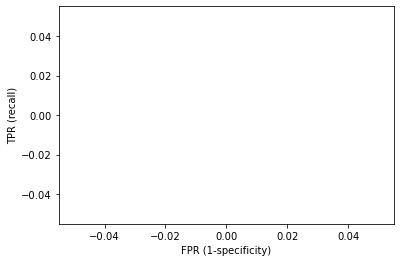

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.599919,0.551209,0.610557,0.648586,0.579306,0.646745
Validation,0.585212,0.545079,0.592481,0.625688,0.565813,0.621955



KNN
╠■■■■■■■■■╣


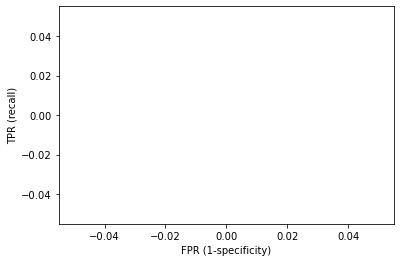

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.999646,0.999293,1.000000,1.000000,0.999646,0.999999
Validation,0.584745,0.549575,0.591799,0.620183,0.567677,0.615202



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+2.388,temperature
+1.769,pulse
+1.252,pam
+1.059,rr
+0.544,sats
+0.254,high_risk_exposure_occupation
-0.065,age
-0.319,high_risk_interactions
-2.853,<BIAS>


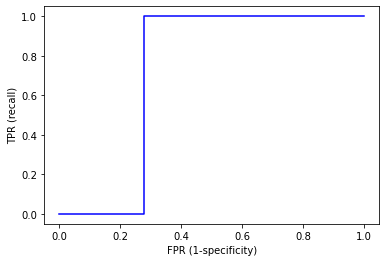

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.601385,0.570217,0.607936,0.632525,0.588436,0.646860
Validation,0.573340,0.552369,0.575332,0.594495,0.561978,0.624768


In [24]:
n_vitals_ex = pd.merge(n_vitals, e_factors, left_index=True, right_index=True)
run_models(n_vitals_ex, y[n_vitals_ex.index], models, ratio_negatives_to_positives=1)

### Assesed Symptoms

In [25]:
a_symptoms.dropna(how="all", inplace=True)

Dummy Random
╠■■■■■■■■■╣


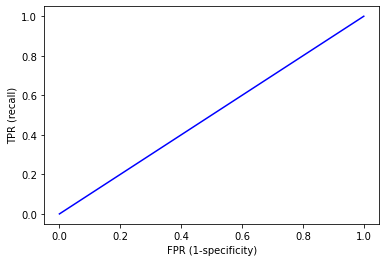

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500070,0.0,0.0,1.0,0.0,0.5
Validation,0.499372,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


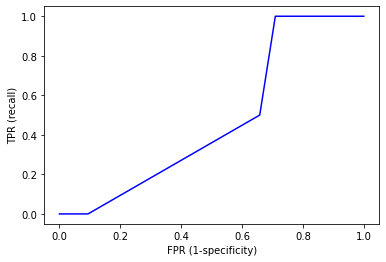

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.539506,0.848466,0.524438,0.230633,0.648195,0.545547
Validation,0.546774,0.847311,0.529306,0.245378,0.651222,0.548674



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.4827 ± 0.9414,days_since_symptom_onset
0.2768 ± 0.8237,ctab
0.2405 ± 0.7967,wheezes
0 ± 0.0000,rhonchi
0 ± 0.0000,labored_respiration


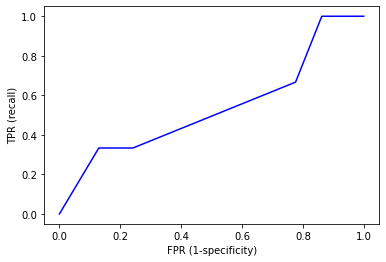

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.593939,0.397691,0.654594,0.790130,0.494644,0.617407
Validation,0.592931,0.394804,0.652759,0.791597,0.490441,0.609892



XGBoost Classifier
╠■■■■■■■■■╣


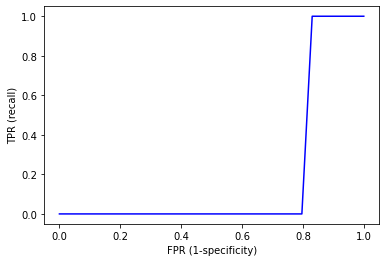

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.605392,0.404957,0.675931,0.805773,0.506383,0.642209
Validation,0.578264,0.385623,0.627726,0.771429,0.476003,0.593595



SVM
╠■■■■■■■■■╣


Weight?,Feature
+1.667,labored_respiration
+1.000,<BIAS>
+0.000,days_since_symptom_onset
-0.000,rhonchi
-0.333,wheezes
-1.667,ctab


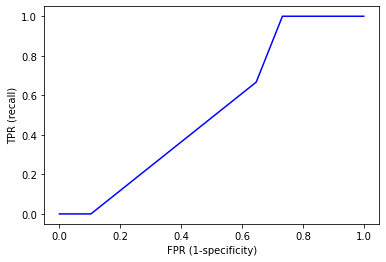

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.536759,0.771937,0.472600,0.301676,0.586120,0.533045
Validation,0.541331,0.768347,0.475865,0.313445,0.587322,0.541771



KNN
╠■■■■■■■■■╣


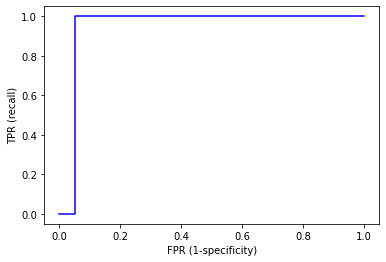

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.605299,0.393686,0.682549,0.816853,0.499250,0.596647
Validation,0.594234,0.375574,0.667154,0.813445,0.479446,0.572574



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+1.514,labored_respiration
+0.132,<BIAS>
-0.016,days_since_symptom_onset
-0.025,rhonchi
-0.212,wheezes
-0.237,ctab


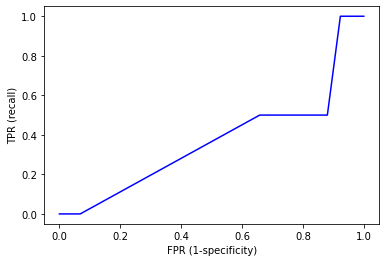

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.548539,0.832353,0.530911,0.264804,0.648265,0.548613
Validation,0.527875,0.823915,0.517872,0.231092,0.635932,0.517193


In [26]:
run_models(a_symptoms, y[a_symptoms.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


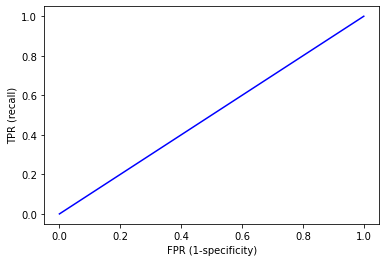

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500070,0.0,0.0,1.0,0.0,0.5
Validation,0.499372,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


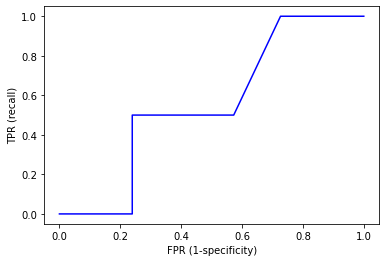

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.546630,0.719654,0.533594,0.373650,0.611031,0.563613
Validation,0.544678,0.717458,0.532787,0.371429,0.608102,0.547564



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.3083 ± 0.8301,age
0.2218 ± 0.7691,days_since_symptom_onset
0.1715 ± 0.6718,high_risk_interactions
0.1322 ± 0.5911,ctab
0.1287 ± 0.6226,high_risk_exposure_occupation
0.0376 ± 0.3400,wheezes
0 ± 0.0000,rhonchi
0 ± 0.0000,labored_respiration


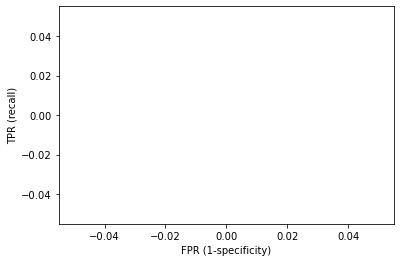

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.588537,0.560853,0.597933,0.616201,0.573218,0.627953
Validation,0.567760,0.537423,0.576333,0.598319,0.549079,0.606219



XGBoost Classifier
╠■■■■■■■■■╣


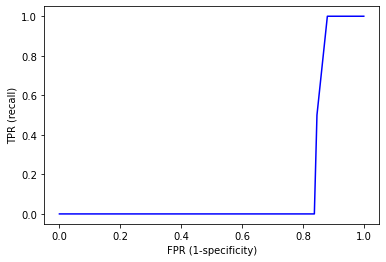

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.646738,0.624103,0.659060,0.669367,0.635570,0.724206
Validation,0.558911,0.522927,0.566046,0.594958,0.538817,0.598956



SVM
╠■■■■■■■■■╣


Weight?,Feature
+1.000,<BIAS>
+1.000,labored_respiration
+0.000,high_risk_exposure_occupation
-0.000,days_since_symptom_onset
-0.000,age
-0.000,rhonchi
-0.001,ctab
-1.999,wheezes
-2.000,high_risk_interactions


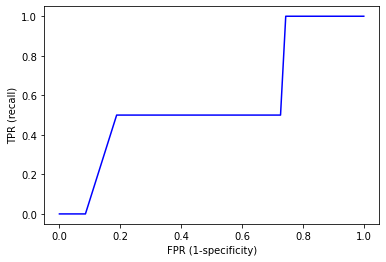

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.551240,0.582806,0.566392,0.519739,0.525941,0.578187
Validation,0.513215,0.525063,0.504196,0.500840,0.476680,0.531787



KNN
╠■■■■■■■■■╣


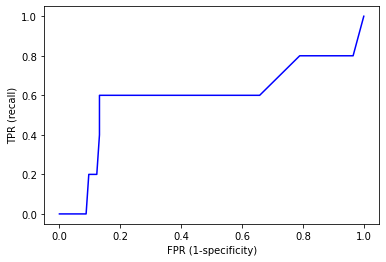

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.645109,0.450033,0.738194,0.840130,0.558991,0.685104
Validation,0.561884,0.357850,0.604495,0.766387,0.448073,0.566472



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+0.645,high_risk_exposure_occupation
+0.542,labored_respiration
+0.182,<BIAS>
+0.152,rhonchi
-0.006,days_since_symptom_onset
-0.054,age
-0.143,ctab
-0.318,wheezes
-0.403,high_risk_interactions


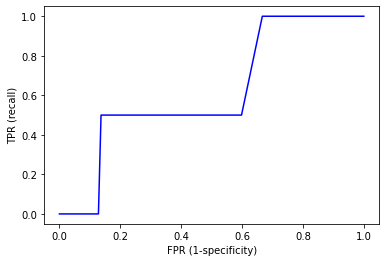

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.569492,0.736227,0.552002,0.402793,0.630247,0.587736
Validation,0.561464,0.721772,0.547039,0.400840,0.621299,0.569028


In [27]:
a_symptoms_ef = pd.merge(a_symptoms, e_factors, left_index=True, right_index=True)
run_models(a_symptoms_ef, y[a_symptoms_ef.index], models, ratio_negatives_to_positives=1)

### Reported symptoms

In [28]:
r_symptoms

,cough,cough_severity,fever,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
0,True,3.0,NaN,False,0.0,False,False,False,False,False,False,False,False
1,True,1.0,False,False,0.0,False,False,False,False,False,False,False,False
2,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,2.0,False,True,2.0,False,True,False,False,False,False,False,True
4,True,1.0,False,False,0.0,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93989,False,0.0,False,False,0.0,False,False,False,False,False,False,False,False
93990,True,2.0,False,False,0.0,False,False,False,False,False,True,False,True
93991,False,0.0,True,False,0.0,False,False,False,False,False,False,False,False
93993,False,0.0,False,False,0.0,False,False,False,False,False,False,False,False


In [29]:
r_symptoms.dropna(how="all", inplace=True)

Dummy Random
╠■■■■■■■■■╣


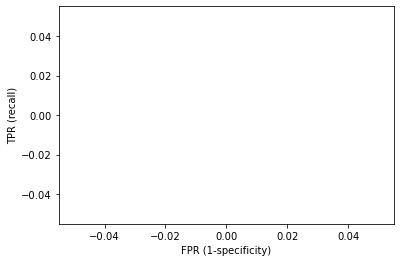

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500045,0.0,0.0,1.0,0.0,0.5
Validation,0.499592,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


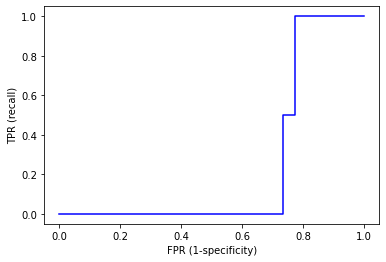

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.629558,0.361975,0.778615,0.897091,0.494051,0.608722
Validation,0.621179,0.351786,0.757517,0.890984,0.476874,0.599105



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.3106 ± 0.8493,cough_severity
0.2698 ± 0.8122,cough
0.1823 ± 0.6392,fever
0.1020 ± 0.5470,fatigue
0.0980 ± 0.5148,headache
0.0373 ± 0.3090,sore_throat
0 ± 0.0000,muscle_sore
0 ± 0.0000,runny_nose
0 ± 0.0000,loss_of_taste
0 ± 0.0000,loss_of_smell


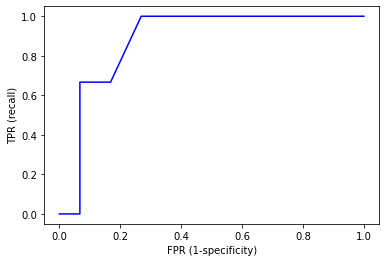

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.634921,0.437900,0.723131,0.831909,0.545131,0.666460
Validation,0.628983,0.436086,0.704620,0.822131,0.535325,0.661994



XGBoost Classifier
╠■■■■■■■■■╣


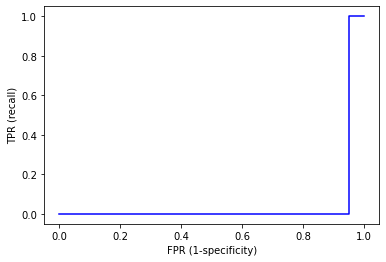

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.704473,0.508365,0.836680,0.900545,0.632293,0.754703
Validation,0.645340,0.445868,0.739282,0.845082,0.553389,0.660484



SVM
╠■■■■■■■■■╣


Weight?,Feature
+2.000,loss_of_smell
+1.999,cough
+0.002,sob
+0.001,muscle_sore
+0.000,runny_nose
-0.000,headache
-0.000,cough_severity
-0.000,loss_of_taste
-0.000,fever
-0.000,sore_throat


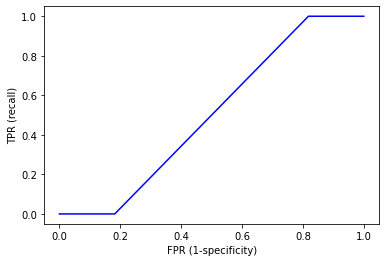

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.652515,0.450085,0.757239,0.854909,0.563760,0.686285
Validation,0.650671,0.439358,0.755660,0.862295,0.551883,0.680706



KNN
╠■■■■■■■■■╣


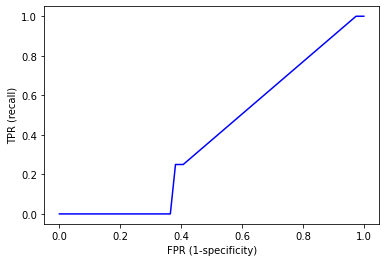

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.702836,0.483178,0.861717,0.922455,0.619068,0.737252
Validation,0.633884,0.427083,0.726991,0.840984,0.535128,0.647800



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+2.164,loss_of_smell
+0.923,loss_of_taste
+0.881,sob
+0.726,cough
+0.629,headache
+0.531,muscle_sore
+0.401,fever
+0.375,cough_severity
+0.052,sore_throat
-0.070,runny_nose


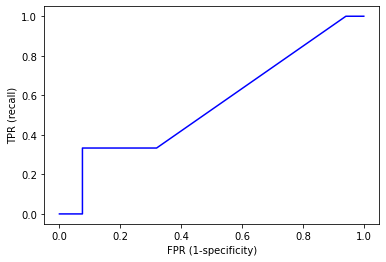

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.665651,0.485360,0.759214,0.845909,0.592022,0.692856
Validation,0.663784,0.482714,0.752911,0.845082,0.585407,0.690246


In [30]:
run_models(r_symptoms, y[r_symptoms.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


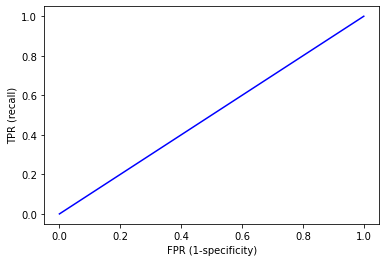

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500045,0.0,0.0,1.0,0.0,0.5
Validation,0.499592,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


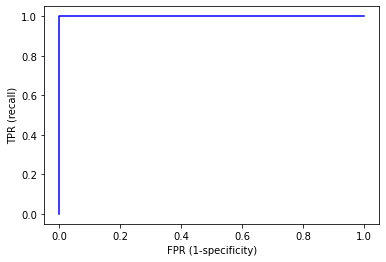

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.620602,0.338064,0.777429,0.903091,0.471043,0.599276
Validation,0.617089,0.337032,0.766886,0.897541,0.462902,0.600204



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.5168 ± 0.9178,cough_severity
0.2400 ± 0.6730,fever
0.1993 ± 0.6603,headache
0.0439 ± 0.3181,fatigue
0 ± 0.0000,sore_throat
0 ± 0.0000,muscle_sore
0 ± 0.0000,runny_nose
0 ± 0.0000,loss_of_taste
0 ± 0.0000,loss_of_smell
0 ± 0.0000,diarrhea


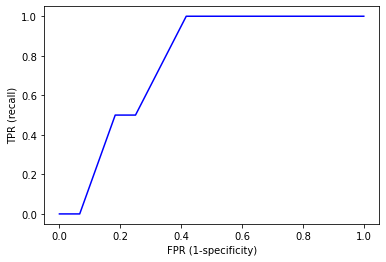

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.639240,0.475812,0.706900,0.802636,0.568600,0.66596
Validation,0.635125,0.470512,0.698021,0.800000,0.559365,0.65947



XGBoost Classifier
╠■■■■■■■■■╣


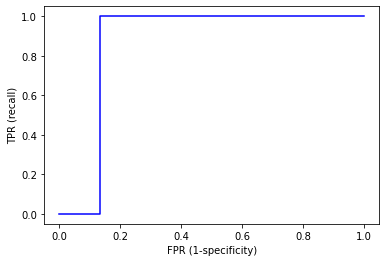

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.704155,0.508999,0.835097,0.899273,0.632274,0.755369
Validation,0.631848,0.434500,0.716763,0.829508,0.539438,0.649048



SVM
╠■■■■■■■■■╣


Weight?,Feature
+1.999,loss_of_smell
+1.499,muscle_sore
+1.001,cough_severity
+0.500,headache
+0.499,runny_nose
+0.000,loss_of_taste
+0.000,fever
-0.001,sore_throat
-0.001,diarrhea
-0.001,sob_severity


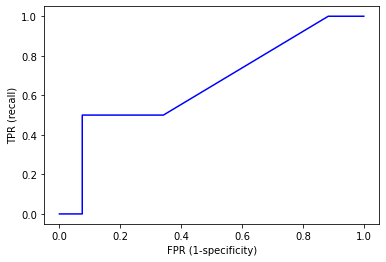

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.661833,0.495184,0.743551,0.828455,0.593874,0.686409
Validation,0.658060,0.487645,0.739980,0.828689,0.584633,0.690614



KNN
╠■■■■■■■■■╣


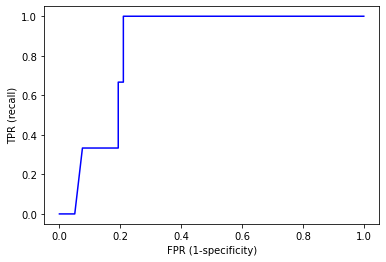

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.705155,0.490543,0.859720,0.919727,0.624498,0.741081
Validation,0.649445,0.434406,0.761307,0.864754,0.549902,0.659973



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+1.695,loss_of_smell
+1.094,loss_of_taste
+0.953,cough_severity
+0.580,muscle_sore
+0.512,headache
+0.407,fever
+0.115,runny_nose
+0.014,fatigue
-0.024,sore_throat
-0.071,diarrhea


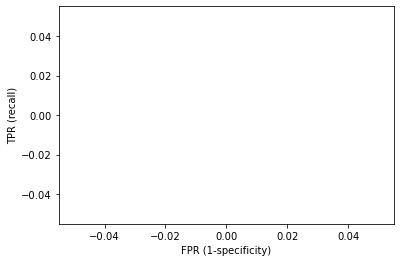

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.662923,0.489176,0.752195,0.836636,0.591478,0.690612
Validation,0.653543,0.482754,0.732093,0.824590,0.578622,0.685823


In [31]:
run_models(r_symptoms.drop(columns=["sob", "cough"]), y[r_symptoms.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


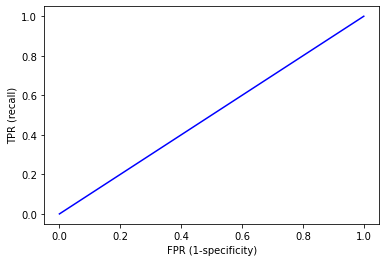

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500045,0.0,0.0,1.0,0.0,0.5
Validation,0.499592,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


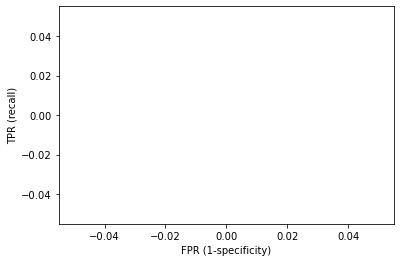

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.613010,0.321968,0.772028,0.904000,0.453862,0.587216
Validation,0.616263,0.320638,0.784068,0.912295,0.449754,0.596805



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.3597 ± 0.8297,cough
0.2714 ± 0.8012,headache
0.1475 ± 0.5450,fever
0.0970 ± 0.5126,muscle_sore
0.0702 ± 0.4629,sore_throat
0.0543 ± 0.3994,fatigue
0 ± 0.0000,runny_nose
0 ± 0.0000,loss_of_taste
0 ± 0.0000,loss_of_smell
0 ± 0.0000,diarrhea


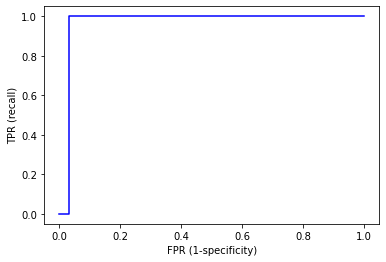

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.635694,0.486084,0.696804,0.785273,0.571089,0.666988
Validation,0.640848,0.479522,0.706807,0.802459,0.565471,0.669602



XGBoost Classifier
╠■■■■■■■■■╣


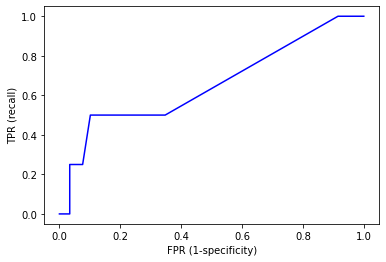

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.694654,0.498181,0.820791,0.891091,0.619869,0.744973
Validation,0.643319,0.440191,0.740776,0.846721,0.550096,0.657265



SVM
╠■■■■■■■■■╣


Weight?,Feature
+2.000,cough
+2.000,loss_of_smell
+1.999,muscle_sore
+0.001,loss_of_taste
+0.000,sore_throat
+0.000,fever
-0.000,headache
-0.000,diarrhea
-0.000,runny_nose
-0.000,fatigue


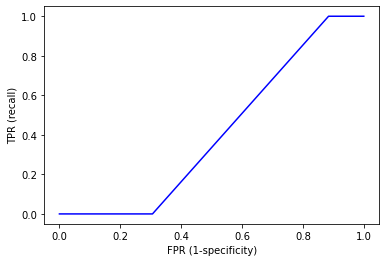

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.653196,0.450813,0.758348,0.855545,0.564598,0.685418
Validation,0.646166,0.445049,0.740090,0.847541,0.551126,0.674848



KNN
╠■■■■■■■■■╣


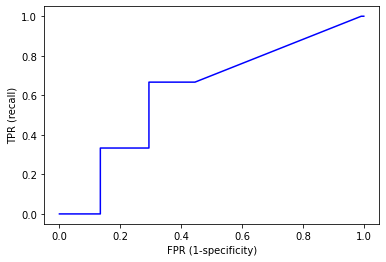

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.698927,0.486452,0.845864,0.911364,0.617524,0.734992
Validation,0.649854,0.431174,0.764103,0.868852,0.548669,0.672718



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+1.377,loss_of_taste
+1.050,cough
+0.789,loss_of_smell
+0.720,headache
+0.653,muscle_sore
+0.439,fever
-0.062,sob
-0.083,diarrhea
-0.155,fatigue
-0.175,sore_throat


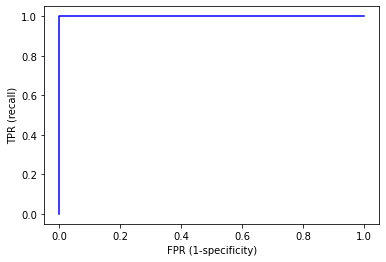

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.660469,0.502179,0.737486,0.818727,0.595892,0.691684
Validation,0.662126,0.498301,0.744414,0.826230,0.590746,0.695285


In [32]:
run_models(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), y[r_symptoms.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


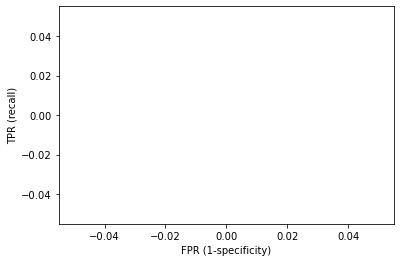

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500070,0.0,0.0,1.0,0.0,0.5
Validation,0.499372,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


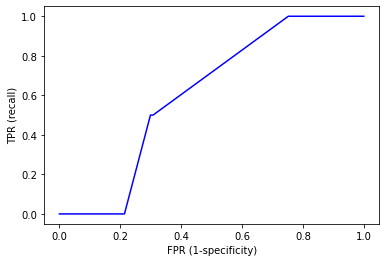

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.645109,0.499674,0.704609,0.790503,0.584673,0.681448
Validation,0.650035,0.494608,0.713499,0.805882,0.581611,0.686213



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.4770 ± 0.9112,cough
0.2192 ± 0.6903,fever
0.1838 ± 0.6822,headache
0.0891 ± 0.4471,days_since_symptom_onset
0.0164 ± 0.2061,fatigue
0.0121 ± 0.1990,ctab
0.0013 ± 0.0222,wheezes
0.0012 ± 0.0203,sore_throat
0 ± 0.0000,rhonchi
0 ± 0.0000,labored_respiration


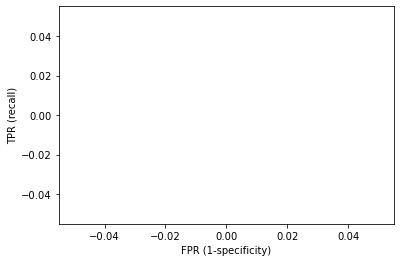

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.642734,0.502002,0.698872,0.783426,0.584054,0.684010
Validation,0.645408,0.500392,0.702577,0.790756,0.581182,0.688054



XGBoost Classifier
╠■■■■■■■■■╣


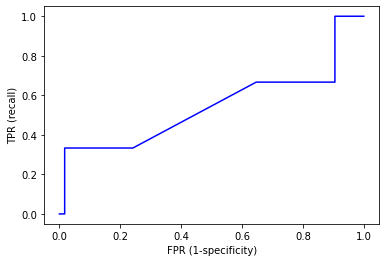

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.759790,0.586942,0.896923,0.932588,0.709497,0.836537
Validation,0.645434,0.470350,0.722353,0.821008,0.566097,0.659681



SVM
╠■■■■■■■■■╣


Weight?,Feature
+2.034,loss_of_smell
+2.000,labored_respiration
+2.000,cough
+1.897,muscle_sore
+0.068,headache
+0.020,sob
+0.000,sore_throat
-0.000,fever
-0.000,wheezes
-0.000,rhonchi


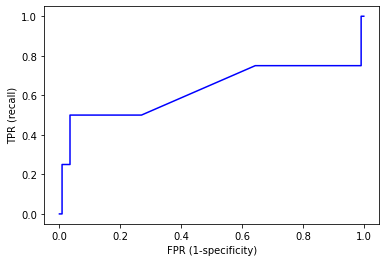

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.657541,0.471458,0.751480,0.843575,0.578739,0.700125
Validation,0.655459,0.466008,0.746235,0.845378,0.570292,0.697092



KNN
╠■■■■■■■■■╣


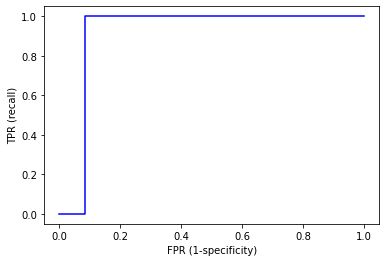

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.765471,0.571856,0.933254,0.959032,0.709078,0.801194
Validation,0.624431,0.456884,0.685177,0.792437,0.546076,0.638873



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+1.718,loss_of_smell
+1.266,cough
+0.966,muscle_sore
+0.862,loss_of_taste
+0.665,headache
+0.460,fever
+0.179,labored_respiration
+0.135,wheezes
+0.127,runny_nose
-0.030,sore_throat


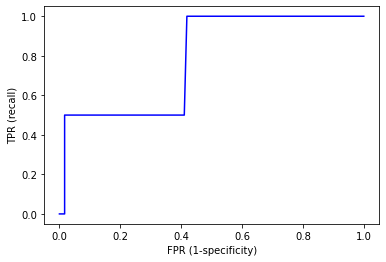

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.668622,0.515409,0.745676,0.821788,0.607999,0.713892
Validation,0.662614,0.508866,0.735147,0.816807,0.595926,0.702480


In [33]:
ra_symptoms = pd.merge(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), a_symptoms, left_index=True, right_index=True)
run_models(ra_symptoms, y[ra_symptoms.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


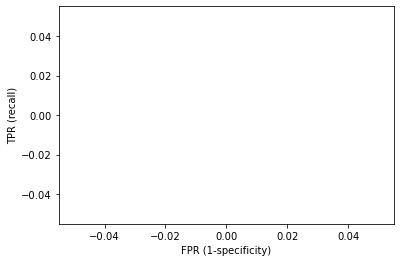

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500045,0.0,0.0,1.0,0.0,0.5
Validation,0.499592,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


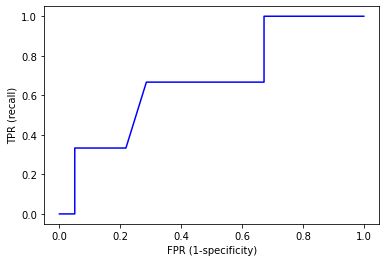

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.642377,0.469722,0.717483,0.815000,0.567668,0.678186
Validation,0.649062,0.465640,0.733269,0.832787,0.566274,0.679341



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.3191 ± 0.8655,cough_severity
0.1682 ± 0.5887,fever
0.1545 ± 0.6363,headache
0.1169 ± 0.5822,fatigue
0.1055 ± 0.5511,high_risk_exposure_occupation
0.0868 ± 0.4151,age
0.0490 ± 0.3179,high_risk_interactions
0 ± 0.0000,sore_throat
0 ± 0.0000,muscle_sore
0 ± 0.0000,runny_nose


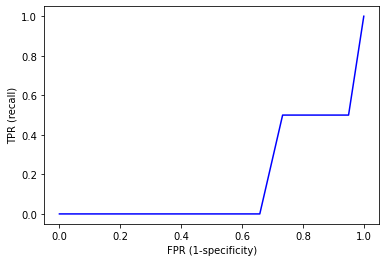

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.642240,0.483813,0.708109,0.800636,0.574804,0.679851
Validation,0.633085,0.476230,0.691101,0.790164,0.559965,0.663926



XGBoost Classifier
╠■■■■■■■■■╣


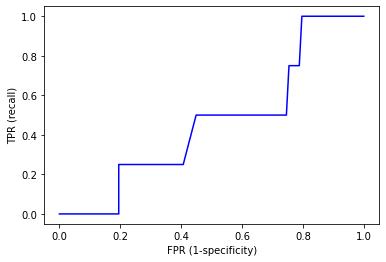

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.748704,0.570378,0.886858,0.92700,0.694068,0.832117
Validation,0.638413,0.452486,0.719685,0.82459,0.553300,0.658914



SVM
╠■■■■■■■■■╣


Weight?,Feature
+1.999,loss_of_smell
+1.000,cough_severity
+1.000,muscle_sore
+1.000,headache
+0.999,loss_of_taste
+0.000,fever
-0.000,age
-0.000,high_risk_exposure_occupation
-0.000,sore_throat
-0.000,runny_nose


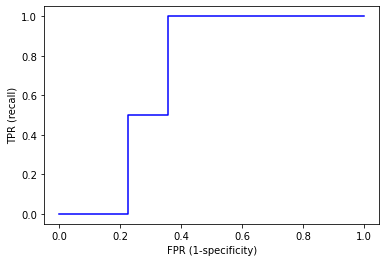

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.659014,0.499087,0.736613,0.818909,0.59371,0.696558
Validation,0.650677,0.493396,0.716465,0.808197,0.58180,0.691190



KNN
╠■■■■■■■■■╣


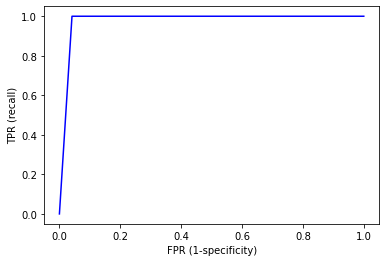

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.748886,0.541279,0.925966,0.956455,0.682993,0.806220
Validation,0.607297,0.379661,0.698570,0.835246,0.488749,0.616315



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+1.569,loss_of_smell
+0.895,loss_of_taste
+0.694,cough_severity
+0.675,muscle_sore
+0.487,headache
+0.398,runny_nose
+0.365,fever
+0.203,high_risk_exposure_occupation
+0.010,age
-0.034,diarrhea


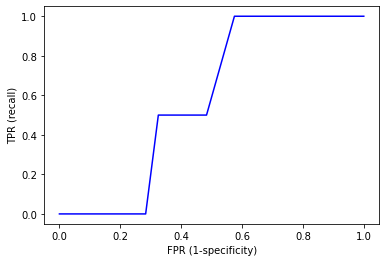

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.658514,0.500637,0.732876,0.816364,0.594226,0.704678
Validation,0.652735,0.488498,0.728973,0.817213,0.580876,0.688120


In [34]:
r_symptoms_ex = pd.merge(r_symptoms.drop(columns=["sob", "cough"]), e_factors, left_index=True, right_index=True)
run_models(r_symptoms_ex, y[r_symptoms_ex.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


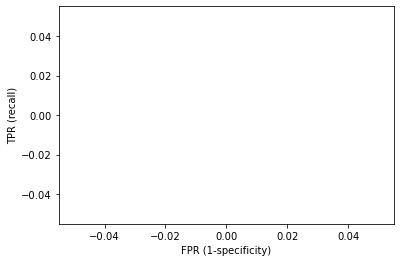

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500227,0.0,0.0,1.0,0.0,0.5
Validation,0.497945,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


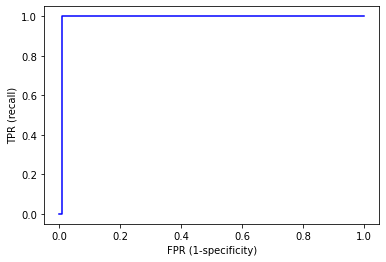

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.660756,0.520777,0.723007,0.800606,0.605383,0.707098
Validation,0.657379,0.520509,0.718249,0.795413,0.601342,0.700559



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.3136 ± 0.7752,cough
0.1878 ± 0.5019,pam
0.1808 ± 0.5022,temperature
0.1028 ± 0.3756,pulse
0.0961 ± 0.4796,headache
0.0673 ± 0.3589,fever
0.0310 ± 0.1546,rr
0.0122 ± 0.1719,fatigue
0.0084 ± 0.0564,sats
0 ± 0.0000,sore_throat


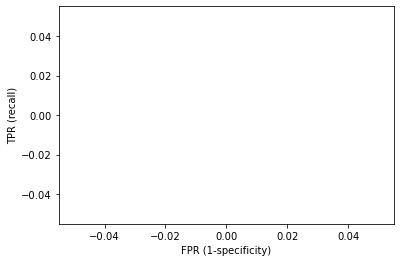

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.661362,0.562332,0.701557,0.760303,0.623885,0.721237
Validation,0.644600,0.545980,0.678925,0.744037,0.601709,0.702326



XGBoost Classifier
╠■■■■■■■■■╣


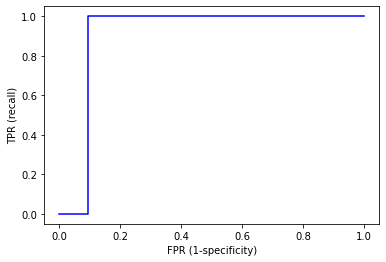

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.999495,0.999394,0.999596,0.999596,0.999494,0.999999
Validation,0.622194,0.600542,0.629478,0.644037,0.613456,0.663450



SVM
╠■■■■■■■■■╣


Weight?,Feature
+1.380,loss_of_smell
+1.326,cough
+1.249,temperature
+1.168,loss_of_taste
+1.053,muscle_sore
+0.314,headache
+0.112,rr
+0.039,sats
+0.020,pulse
+0.000,pam


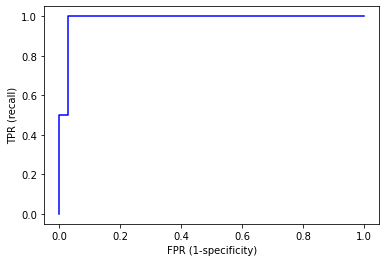

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.663382,0.469417,0.767527,0.857172,0.581837,0.736650
Validation,0.667417,0.463161,0.785020,0.873394,0.578880,0.730905



KNN
╠■■■■■■■■■╣


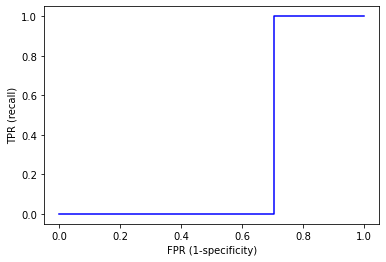

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.999545,0.999090,1.000000,1.000000,0.999544,0.999999
Validation,0.580187,0.526847,0.592234,0.633945,0.555923,0.619239



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+1.536,loss_of_smell
+1.328,cough
+1.074,muscle_sore
+0.798,headache
+0.789,loss_of_taste
+0.662,runny_nose
+0.213,sob
+0.183,temperature
+0.089,fever
+0.036,rr


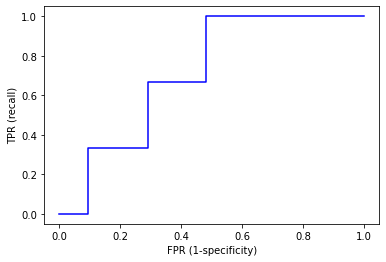

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.673993,0.547672,0.732759,0.800202,0.626699,0.732337
Validation,0.652834,0.534112,0.708239,0.772477,0.605014,0.705749


In [35]:
r_symptoms_vitals = pd.merge(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), vitals, left_index=True, right_index=True)
run_models(r_symptoms_vitals, y[r_symptoms_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


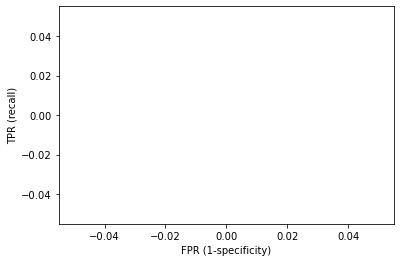

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500127,0.0,0.0,1.0,0.0,0.5
Validation,0.498858,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


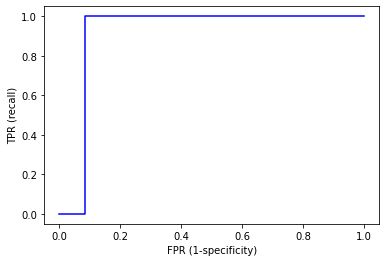

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.656505,0.527757,0.710738,0.785193,0.605596,0.706779
Validation,0.647614,0.520525,0.695659,0.775229,0.593912,0.688976



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.2568 ± 0.6556,pulse
0.2270 ± 0.7332,cough
0.1604 ± 0.5804,temperature
0.1069 ± 0.4774,pam
0.0593 ± 0.3598,rr
0.0590 ± 0.3916,headache
0.0520 ± 0.3445,days_since_symptom_onset
0.0361 ± 0.2833,fever
0.0268 ± 0.2222,sats
0.0083 ± 0.0839,wheezes


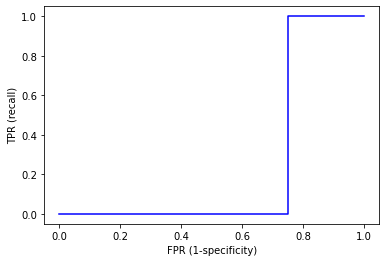

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.667309,0.576656,0.704566,0.757911,0.633941,0.728588
Validation,0.652608,0.559783,0.686983,0.745872,0.614884,0.703747



XGBoost Classifier
╠■■■■■■■■■╣


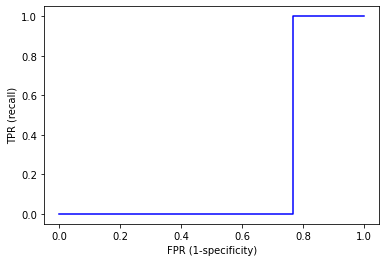

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.999696,0.999391,1.000000,1.000000,0.999695,1.000
Validation,0.618765,0.608182,0.621438,0.629358,0.613810,0.679



SVM
╠■■■■■■■■■╣


Weight?,Feature
+1.875,loss_of_smell
+1.653,cough
+1.214,muscle_sore
+0.492,labored_respiration
+0.447,headache
+0.381,temperature
+0.258,loss_of_taste
+0.120,wheezes
+0.096,runny_nose
+0.054,fever


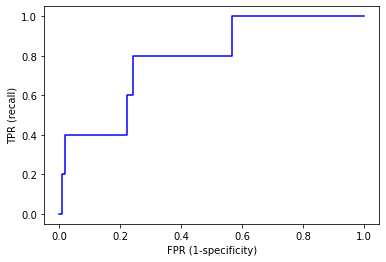

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.667562,0.476305,0.771846,0.858722,0.588678,0.740153
Validation,0.662679,0.475771,0.758471,0.850459,0.579647,0.723207



KNN
╠■■■■■■■■■╣


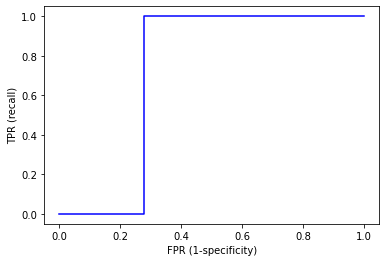

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.999848,0.999696,1.000000,1.00000,0.999848,1.000000
Validation,0.579823,0.520434,0.588944,0.63945,0.550477,0.606463



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+1.585,loss_of_smell
+1.431,cough
+0.837,muscle_sore
+0.724,loss_of_taste
+0.504,fever
+0.310,headache
+0.105,labored_respiration
+0.094,diarrhea
+0.071,temperature
+0.070,rr


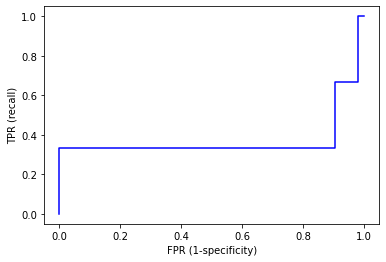

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.676337,0.556567,0.731831,0.796045,0.632103,0.735150
Validation,0.666336,0.540601,0.721625,0.792661,0.615120,0.719134


In [36]:
ra_symptoms_vitals = pd.merge(ra_symptoms, vitals, left_index=True, right_index=True)
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


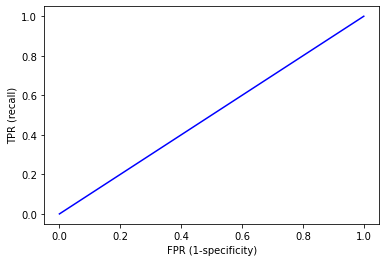

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500045,0.0,0.0,1.0,0.0,0.5
Validation,0.499592,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


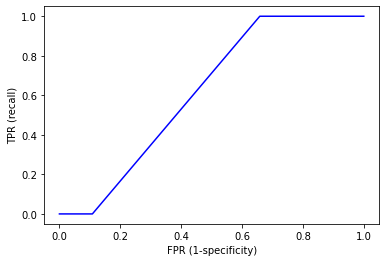

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.640921,0.413073,0.759021,0.868727,0.534793,0.644451
Validation,0.639644,0.418099,0.754110,0.861475,0.534367,0.647677



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.3086 ± 0.7669,cough
0.1936 ± 0.6469,headache
0.1652 ± 0.5483,fever
0.1366 ± 0.5505,muscle_sore
0.1026 ± 0.4732,sore_throat
0.0934 ± 0.4630,fatigue
0 ± 0.0000,loss_of_taste
0 ± 0.0000,sob
0 ± 0.0000,diarrhea
0 ± 0.0000,loss_of_smell


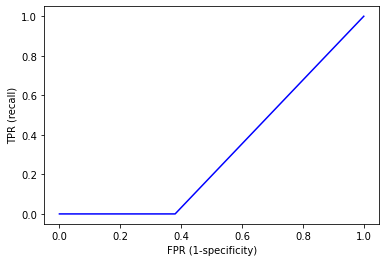

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.636149,0.468357,0.704982,0.803909,0.562643,0.667966
Validation,0.635935,0.467233,0.703481,0.804918,0.557601,0.665018



XGBoost Classifier
╠■■■■■■■■■╣


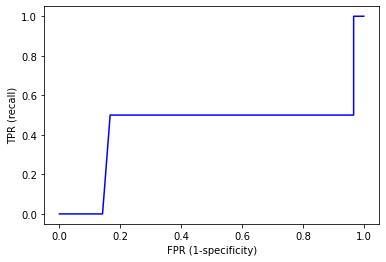

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.714565,0.529825,0.840887,0.899273,0.649777,0.778984
Validation,0.640860,0.446735,0.728238,0.835246,0.552754,0.657664



SVM
╠■■■■■■■■■╣


Weight?,Feature
+2.000,loss_of_smell
+2.000,cough
+1.333,loss_of_taste
+1.333,headache
+0.667,muscle_sore
+0.000,fever
-0.000,sore_throat
-0.000,htn
-0.000,diarrhea
-0.000,diabetes


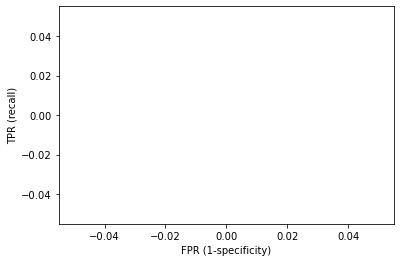

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.654150,0.454535,0.757454,0.853727,0.567103,0.697807
Validation,0.649451,0.446735,0.749380,0.852459,0.554722,0.690680



KNN
╠■■■■■■■■■╣


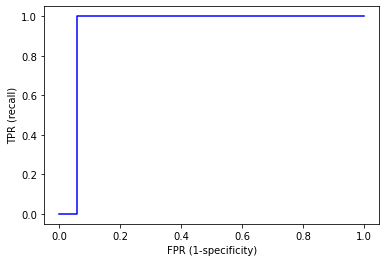

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.714065,0.513183,0.858583,0.914909,0.642117,0.760550
Validation,0.642496,0.432834,0.744558,0.852459,0.544391,0.652243



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+1.607,loss_of_smell
+1.298,cough
+0.978,loss_of_taste
+0.725,diabetes
+0.633,muscle_sore
+0.578,chd
+0.567,headache
+0.296,fever
+0.164,runny_nose
-0.008,diarrhea


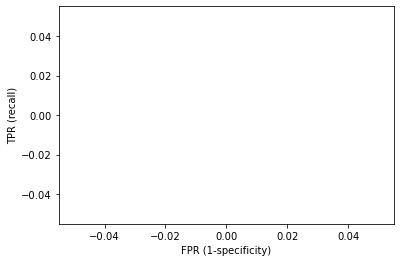

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.668061,0.491362,0.759929,0.844727,0.596734,0.706516
Validation,0.657625,0.481881,0.741484,0.833607,0.579518,0.693732


In [37]:
r_symptoms_comorb = pd.merge(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), comorb, left_index=True, right_index=True)
run_models(r_symptoms_comorb, y[r_symptoms_comorb.index], models, ratio_negatives_to_positives=1)

In [38]:
a = pd.Series(np.array([True, False, True, False]))
b = pd.Series(np.array([True, True, False, False]))

In [39]:
(a ^ b)

0    False
1     True
2     True
3    False
dtype: bool

Next step is to determine which features are useful in the case of each dataset, eliminating them one by one(and maybe applying normalization to the vitals).
After that, we select the 2 (first just 2) best models and somehow combine them to make an ensemble model.<br>
<i>Idea: One model for each metric so 4 models with the highest metrics and then figure out some boolean operation to combine them</i><br>
<i>Idea 2: The boolean operation can be found by using a Decision Tree. After all they are good at finding simple rules</i><br>
<i>Idea 3: The boolean operation taking the highest precision and the highest recall would be an AND. Maybe the inverse for another 2 metrics as well</i>

In [40]:
class CustomModel():

    def __init__(self):
        self.model_1 = LogisticRegression() #The best model (has very high accuracy and precission but not very good recall. Good for determining Positive results)
        self.model_2 = RandomForestClassifier() #The one with the best recall. Poor specificity and precision but high recall. Good for determining Negative results
        self.model_3 = XGBAdapter() #The one with high accuracy, and balanced recall and precision. If none of the other 2 are sure this is the tie breaker
        self.imputer = Imputer()
        
    def fit(self, data_x, data_y):
        self.imputer.fit(data_x, data_y)
        
        data_1 = data_x.iloc[:,16:]
        data_2 = data_x.iloc[:,:10]
        data_3 = pd.merge(data_x.iloc[:,10-16].drop(columns=["sys", "dia"]), data_x.iloc[:,21:], left_index=True, right_index=True)
        self.model_1.fit(data_1, data_y[data_1.index])
        self.model_2.fit(data_2, data_y[data_2.index])
        self.model_3.fit(data_3, data_y[data_3.index])
        
    def predict(self, data_x):
        data_1 = data_x.iloc[:,16:]
        data_2 = data_x.iloc[:,:10]
        data_3 = pd.merge(data_x.iloc[:,10-16].drop(columns=["sys", "dia"]), data_x.iloc[:,21:], left_index=True, right_index=True)
                
        preds_1 = self.model_1.predict(data_1)
        preds_2 = self.model_2.predict(data_2)
        preds_3 = self.model_3.predict(data_3)
        
        preds_1[preds_1 == "Positive"] = True
        preds_1[preds_1 == "Negative"] = False
        preds_2[preds_2 == "Positive"] = True
        preds_2[preds_2 == "Negative"] = False
        preds_3[preds_3 == "Positive"] = True
        preds_3[preds_3 == "Negative"] = False
        
        final_preds = ((preds_1)| (preds_2 & preds_3)) #If predicted positive by model 1 then we keep that prediction. If predicted negative by model 2, we try to keep it. In case preds1 is False and preds2 is True the final decision is with preds3
        
        #final_preds = np.sum(np.array([preds_1, preds_2, preds_3]), axis = 0)
        
        #final_preds[final_preds <=1] = "Negative"
        #final_preds[final_preds != "Negative" ] = "Positive"
        final_preds[final_preds == True] = "Positive"
        final_preds[final_preds == False] = "Negative"
        
        
        return final_preds

In [41]:
run_models(X, y, {"FirstEnsembleModel" : CustomModel()}, folds=10, ratio_negatives_to_positives=1)

FirstEnsembleModel
'CustomModel' object has no attribute 'predict_proba'


In [42]:
weights=(np.ones(y[ra_symptoms_vitals.index].shape) + (y[ra_symptoms_vitals.index]=="Negative"))

In [43]:
ensemble_models = {
    "LogisticVanilla" : LogisticRegression(),
    "LogisticStrongRegularization" : LogisticRegression(C=.5),
    "LogisticWeakRegularization" : LogisticRegression(C=2),
    "Logisctic"
    "AdaBoost" : AdaBoostClassifier(base_estimator=LogisticRegression())
}



In [44]:
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], {"Ada" : AdaBoostClassifier(base_estimator=LogisticRegression())}, folds=10, ratio_negatives_to_positives=1)

Ada
╠■■■■■■■■■╣
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.681968,0.594417,0.720523,0.769473,0.651360,0.737552
Validation,0.679169,0.584370,0.721284,0.774312,0.643325,0.723453


LogisticVanilla
╠■■■■■■■■■╣


Weight?,Feature
+2.112,loss_of_smell
+1.666,loss_of_taste
+0.853,muscle_sore
+0.824,cough
+0.796,headache
+0.640,diabetes
+0.531,high_risk_exposure_occupation
+0.394,cough_severity
+0.368,labored_respiration
+0.176,fever


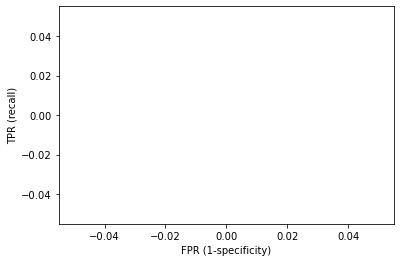

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.678379,0.57683,0.723848,0.779909,0.641922,0.747936
Validation,0.660488,0.55717,0.701475,0.763934,0.619410,0.727376



LogisticStrongRegularization
╠■■■■■■■■■╣


Weight?,Feature
+1.236,loss_of_smell
+0.997,loss_of_taste
+0.869,cough
+0.852,muscle_sore
+0.575,headache
+0.509,labored_respiration
+0.240,sob
+0.183,rhonchi
+0.182,cancer
+0.171,fever


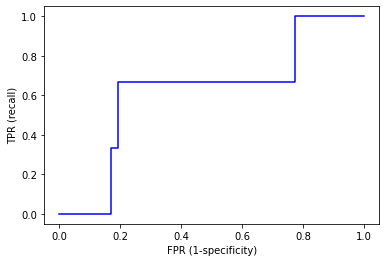

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.678880,0.579013,0.723579,0.778727,0.643189,0.748601
Validation,0.661308,0.557997,0.703789,0.764754,0.619744,0.725846



LogisticWeakRegularization
╠■■■■■■■■■╣


Weight?,Feature
+1.833,loss_of_smell
+1.455,loss_of_taste
+1.178,muscle_sore
+0.792,cough
+0.436,fever
+0.313,htn
+0.279,cough_severity
+0.223,labored_respiration
+0.211,high_risk_exposure_occupation
+0.209,headache


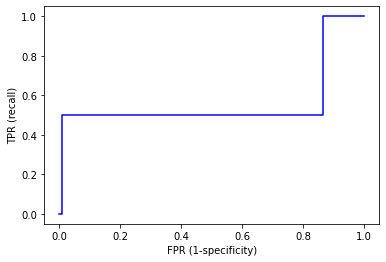

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.679198,0.574559,0.726689,0.783818,0.641673,0.747558
Validation,0.661736,0.547368,0.710319,0.776230,0.616754,0.729073



LogiscticAdaBoost
╠■■■■■■■■■╣
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.679835,0.581834,0.723768,0.777818,0.645015,0.742363
Validation,0.678496,0.563728,0.732552,0.793443,0.635123,0.738278


In [45]:
run_models(X.drop(columns=["sys", "dia"]), y, ensemble_models, ratio_negatives_to_positives=1)

In [46]:
ada_configurations = {
    "Ada Vanilla" : AdaBoostClassifier(),
    "Ada Logistic" : AdaBoostClassifier(base_estimator=LogisticRegression()),
    "Ada algo" : AdaBoostClassifier(algorithm="SAMME"),
    "Ada learning rate" : AdaBoostClassifier(learning_rate=.5),
    "Ada complete" : AdaBoostClassifier(base_estimator=LogisticRegression(C=.5), algorithm="SAMME", learning_rate=.5)
    
}

Ada Vanilla
╠■■■■■■■■■╣


Weight,Feature
0.2000 ± 0.8000,pulse
0.2000 ± 0.8000,temperature
0.0600 ± 0.4750,sats
0.0600 ± 0.4750,days_since_symptom_onset
0.0400 ± 0.3919,loss_of_smell
0.0400 ± 0.3919,age
0.0200 ± 0.2800,high_risk_exposure_occupation
0.0200 ± 0.2800,sore_throat
0.0200 ± 0.2800,rr
0.0200 ± 0.2800,high_risk_interactions


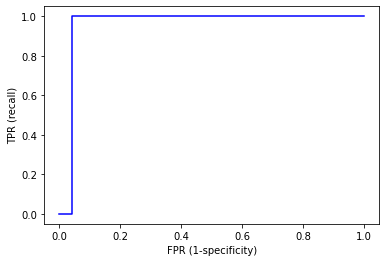

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.693199,0.601743,0.736825,0.784636,0.662119,0.767851
Validation,0.646961,0.548934,0.681832,0.745082,0.605948,0.718134



Ada Logistic
╠■■■■■■■■■╣
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.678971,0.588196,0.718753,0.769727,0.646877,0.741469
Validation,0.668687,0.572724,0.709924,0.764754,0.631430,0.729316



Ada algo
╠■■■■■■■■■╣


Weight,Feature
0.2531 ± 0.7684,loss_of_smell
0.1363 ± 0.6940,loss_of_taste
0.1321 ± 0.6499,temperature
0.0978 ± 0.6000,pulse
0.0949 ± 0.2800,cough_severity
0.0789 ± 0.8773,days_since_symptom_onset
0.0755 ± 0.3919,muscle_sore
0.0307 ± 0.4750,asthma
0.0303 ± 0.2800,age
0.0298 ± 0.2800,rhonchi


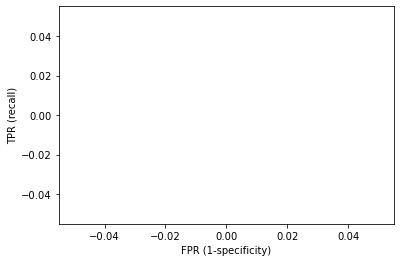

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.673243,0.631465,0.690692,0.715000,0.658350,0.737844
Validation,0.636327,0.592476,0.650025,0.680328,0.618285,0.704386



Ada learning rate
╠■■■■■■■■■╣


Weight,Feature
0.2000 ± 0.8000,temperature
0.1600 ± 0.7332,pulse
0.0800 ± 0.5426,days_since_symptom_onset
0.0600 ± 0.4750,cough_severity
0.0600 ± 0.4750,loss_of_smell
0.0600 ± 0.4750,rr
0.0400 ± 0.3919,loss_of_taste
0.0400 ± 0.3919,diabetes
0.0400 ± 0.3919,sats
0.0400 ± 0.3919,muscle_sore


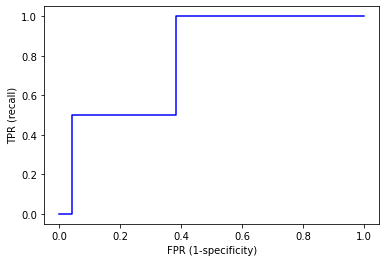

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.687426,0.579104,0.739560,0.795727,0.649352,0.763742
Validation,0.655592,0.546508,0.699543,0.764754,0.610641,0.718535



Ada complete
╠■■■■■■■■■╣
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.664605,0.612197,0.684269,0.717000,0.645964,0.710918
Validation,0.647012,0.587538,0.664183,0.706557,0.621815,0.689274


In [47]:
run_models(X.drop(columns=["sys", "dia"]), y, ada_configurations, ratio_negatives_to_positives=1)

Ada Vanilla
╠■■■■■■■■■╣


Weight,Feature
0.2400 ± 0.8542,pam
0.2400 ± 0.8542,temperature
0.1400 ± 0.6940,pulse
0.0800 ± 0.5426,days_since_symptom_onset
0.0400 ± 0.3919,rr
0.0400 ± 0.3919,loss_of_smell
0.0400 ± 0.3919,sats
0.0200 ± 0.2800,wheezes
0.0200 ± 0.2800,sore_throat
0.0200 ± 0.2800,fever


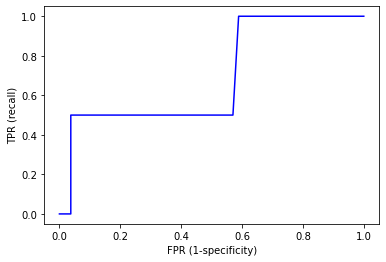

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.694600,0.602638,0.738991,0.786511,0.663575,0.764982
Validation,0.662685,0.541485,0.715792,0.784404,0.614582,0.716114



Ada Logistic
╠■■■■■■■■■╣
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.681309,0.588028,0.722828,0.774544,0.648395,0.738334
Validation,0.677778,0.585271,0.717934,0.770642,0.643277,0.726408



Ada algo
╠■■■■■■■■■╣


Weight,Feature
0.1933 ± 0.8773,pam
0.1494 ± 0.7684,loss_of_taste
0.1478 ± 0.7684,pulse
0.1193 ± 0.5426,loss_of_smell
0.1007 ± 0.6940,days_since_symptom_onset
0.0838 ± 0.4750,temperature
0.0837 ± 0.2800,cough
0.0512 ± 0.3919,headache
0.0379 ± 0.2800,rhonchi
0.0328 ± 0.2800,rr


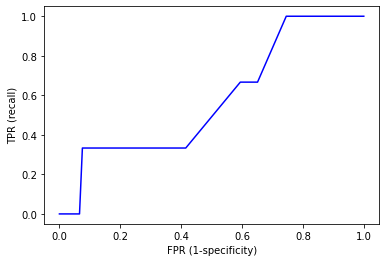

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.677353,0.602134,0.710439,0.752535,0.650718,0.738030
Validation,0.659000,0.590717,0.685604,0.727523,0.631993,0.712838



Ada learning rate
╠■■■■■■■■■╣


Weight,Feature
0.2200 ± 0.8285,pam
0.1800 ± 0.7684,temperature
0.1200 ± 0.6499,pulse
0.0800 ± 0.5426,rr
0.0800 ± 0.5426,days_since_symptom_onset
0.0600 ± 0.4750,cough
0.0400 ± 0.3919,fatigue
0.0400 ± 0.3919,headache
0.0400 ± 0.3919,loss_of_smell
0.0400 ± 0.3919,muscle_sore


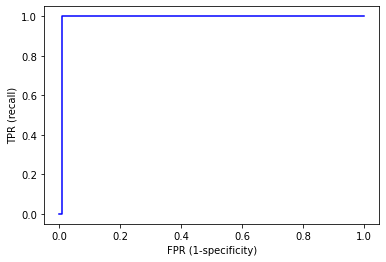

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.695664,0.579201,0.754936,0.812069,0.655407,0.762609
Validation,0.666809,0.549650,0.717398,0.784404,0.620243,0.715648



Ada complete
╠■■■■■■■■■╣
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.660917,0.613598,0.678935,0.708215,0.644071,0.711263
Validation,0.648967,0.585338,0.671609,0.712844,0.624129,0.697352


In [48]:
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], ada_configurations, ratio_negatives_to_positives=1)

## Sidequest: Understanding logistic regression

In [ ]:
lr = LogisticRegression()
imp = Imputer()
imp.fit_transform(all_data, y[all_data.index])
lr.fit(all_data, y[all_data.index], sample_weight=(np.ones(y[all_data.index].shape) + (y[all_data.index]=="Negative")))

In [ ]:
lr_preds = lr.predict(all_data)

In [ ]:
manual_preds = np.dot(all_data, lr.coef_.transpose()) + lr.intercept_ #The dot product of coeficients and features plus the bias

In [ ]:
from math import exp
def logistic_function(value):
    return 1 / (1 + exp(-value))

In [ ]:
manual_preds.flatten()

In [ ]:
lfv = np.vectorize(logistic_function) #To vectorize means to apply it to vectors

In [ ]:
result = pd.Series(lfv(manual_preds).flatten())
result[result > .5] = "Positive"
result[result != "Positive"] = "Negative"

In [ ]:
a = np.array([[1,2,3,4,5],[2,4,6,8,10]])
b = np.ones((5,2))
b[:,1] *= 2

In [ ]:
np.dot(a, b)

In [ ]:
lfv(manual_preds)[lfv(manual_preds) > .5]

In [ ]:
explainer = shap.KernelExplainer(lr.predict_proba, np.zeros((1,all_data.columns.size)))

In [ ]:
shap_values = explainer.shap_values(all_data[y[all_data.index] == "Positive"].sample(1))

In [ ]:
shap_values

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1], all_data.columns)

In [ ]:
ra_symptoms_vitals.columns

In [ ]:
def calculate_shap_values(model, data_x):
    explainer = shap.KernelExplainer(model.predict_proba, np.zeros((1, data_x.shape[1])))
    sample = data_x.sample(1)
    shap.initjs()
    display(shap.force_plot(explainer.expected_value[1], explainer.shap_values(sample)[1], sample))

In [ ]:
lr.fit(all_data, y[all_data.index])
calculate_shap_values(lr, all_data)

In [ ]:
y[all_data.index].value_counts()

In [ ]:
all_data["sats"]